#### Code for NWchem-Qiskit Driver
##### 1. import package

In [2]:
import numpy as np
import json
import sys
import yaml
import os
import matplotlib.pyplot as plt
import pylab
from numpy.polynomial.polynomial import Polynomial


from qiskit_nwchem_driver import nwchem_driver
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.problems import EigenstateResult
from qiskit_nature.second_q.mappers.qubit_mapper import QubitMapper

from qiskit.exceptions import QiskitError
from qiskit_algorithms import VQE
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from qiskit.primitives import BaseEstimator
from qiskit.primitives import StatevectorEstimator
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD, UCC
from qiskit_nwchem_driver.nwchem2yaml import extract_fields
from qiskit_nwchem_driver.vqe_avg import run_vqe_with_averaging


from qiskit.visualization import plot_histogram
from qiskit.visualization.timeline import draw, IQXSimple
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeKyiv, FakeValenciaV2, FakeKyoto, FakeVigoV2
from qiskit.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi
from itertools import product



from quantum_gates.simulators import MrAndersonSimulator
from quantum_gates.gates import standard_gates, noise_free_gates, numerical_gates, almost_noise_free_gates 
from quantum_gates.circuits import EfficientCircuit, BinaryCircuit
from quantum_gates.utilities import DeviceParameters
from quantum_gates.utilities import setup_backend
from quantum_gates.utilities import fix_counts

from qiskit import transpile
from qiskit.visualization import plot_circuit_layout
from qiskit_aer import Aer, AerSimulator
from qiskit import transpile, assemble
from qiskit_aer import StatevectorSimulator
from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit
from qiskit_aer.noise import NoiseModel
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer.primitives import Estimator as AerEstimator


#from slowquant.qiskit_interface.wavefunction import WaveFunction
#from slowquant.qiskit_interface.interface import QuantumInterface
#from slowquant.qiskit_interface.custom_ansatz import SDSfUCC, fUCC, tUPS



IBM_TOKEN='3199f66b51cb6ae29b8ea6b1033fc2918545d7426a4bd5e4e065123f19929d6d35e770b6e3f6b6e73f129baeee664be3a106d81f92b3a66be1f17ede8fbc83a6'


In [3]:
# data_dir = os.path.join("qe_files", "n2", "output")
# datafile = os.path.join(data_dir, "demo.out")
# data_file_yaml = os.path.join(data_dir, "demo.yaml")

data_dir = os.path.join("..","data","PW_LiH_data", "3x3_periodic", "NWChem",'1covo')
datafile = os.path.join(data_dir, "H1Li1-2.0.out")
data_file_yaml = os.path.join(data_dir, "H1Li1-2.0.yaml")

##### 2. nwchem output to yaml

In [4]:
data = extract_fields(datafile)
with open(data_file_yaml, 'w') as f:
    f.write(yaml.dump(data, default_flow_style=False)) 

##### 3. data to Qiskit electron structure problem class

In [5]:
driver = nwchem_driver.NWchem_Driver(data_file_yaml)
es_problem = driver.run()
hamiltonian  = es_problem.hamiltonian
print(hamiltonian)
second_q_op = hamiltonian.second_q_op()
print(second_q_op)

h_ij up-down equal: True
eri up-down equal: True
eri up-(down-up) equal: False
eri (up-down)-(down-up) equal: True
Fermionic Operator
number spin orbitals=4, number terms=48
  0.0620810131 * ( +_0 +_2 -_2 -_0 )
+ -0.03120481085 * ( +_0 +_2 -_3 -_0 )
+ -0.03120481085 * ( +_0 +_3 -_2 -_0 )
+ 0.028375930725 * ( +_0 +_3 -_3 -_0 )
+ 0.028375930725 * ( +_0 +_0 -_1 -_1 )
+ 0.053516168575 * ( +_0 +_1 -_0 -_1 )
+ -0.03120481085 * ( +_0 +_2 -_2 -_1 )
+ 0.028375930725 * ( +_0 +_2 -_3 -_1 )
+ 0.053516168575 * ( +_0 +_3 -_2 -_1 )
+ -0.030104954625 * ( +_0 +_3 -_3 -_1 )
+ 0.053516168575 * ( +_1 +_0 -_1 -_0 )
+ 0.028375930725 * ( +_1 +_1 -_0 -_0 )
+ -0.03120481085 * ( +_1 +_2 -_2 -_0 )
+ 0.053516168575 * ( +_1 +_2 -_3 -_0 )
+ 0.028375930725 * ( +_1 +_3 -_2 -_0 )
+ -0.030104954625 * ( +_1 +_3 -_3 -_0 )
+ 0.028375930725 * ( +_1 +_2 -_2 -_1 )
+ -0.030104954625 * ( +_1 +_2 -_3 -_1 )
+ -0.030104954625 * ( +_1 +_3 -_2 -_1 )
+ 0.0518915698 * ( +_1 +_3 -_3 -_1 )
+ 0.0620810131 * ( +_2 +_0 -_0 -_2 )
+ -0.0312

##### 4. Mapping Hamiltonian to qubit

In [5]:
mapper = JordanWignerMapper()

In [6]:
hamiltonian_mapped =mapper.map(second_q_op)
print(hamiltonian_mapped)

SparsePauliOp(['IIII', 'IIIZ', 'IZII', 'IZIZ', 'YYII', 'YYIZ', 'XXII', 'XXIZ', 'ZIII', 'ZIIZ', 'IIZI', 'IIZZ', 'IIYY', 'IZYY', 'IIXX', 'IZXX', 'XYXY', 'YYYY', 'XXYY', 'YXXY', 'XYYX', 'YYXX', 'XXXX', 'YXYX', 'ZIYY', 'ZIXX', 'IZZI', 'YYZI', 'XXZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.6482921 +0.j,  0.24387462+0.j,  0.24387462+0.j,  0.03104051+0.j,
  0.03175493+0.j,  0.01560241+0.j,  0.03175493+0.j,  0.01560241+0.j,
  0.06434841+0.j,  0.01418797+0.j,  0.06434841+0.j, -0.02675808+0.j,
  0.03175493+0.j,  0.01560241+0.j,  0.03175493+0.j,  0.01560241+0.j,
  0.00628506+0.j,  0.02047302+0.j,  0.02047302+0.j, -0.00628506+0.j,
 -0.00628506+0.j,  0.02047302+0.j,  0.02047302+0.j,  0.00628506+0.j,
  0.01505248+0.j,  0.01505248+0.j,  0.01418797+0.j,  0.01505248+0.j,
  0.01505248+0.j,  0.02594578+0.j, -0.02675808+0.j])


##### 5. specify ansatz

<class 'qiskit_nature.second_q.circuit.library.ansatzes.uccsd.UCCSD'>


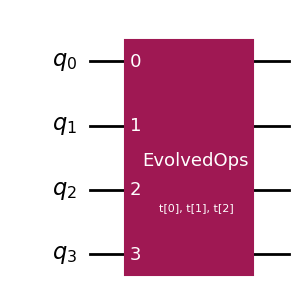

In [7]:
ansatz_uccsd = UCCSD(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
        reps = 1,
        initial_state=HartreeFock(
            es_problem.num_spatial_orbitals,
            es_problem.num_particles,
            mapper,
        ),
    )
print(type(ansatz_uccsd))
#ansatz_uccsd.draw('mpl')
#ansatz_uccsd=ansatz_uccsd.decompose()
ansatz_uccsd.draw('mpl')

##### 6. Add measurement

In [8]:
# directly with qiskit import a real device
provider = QiskitRuntimeService(channel= 'ibm_quantum', token=IBM_TOKEN)
provider.backends() 
backend_real = provider.backend('ibm_kyiv')

# fake backend without the use of the IBM_TOKEN to run the simulation
backend_fake = FakeKyiv()

n_qubit = 4
n_classic_bit = 4
linear_qubit_layout = [0,1,2,3] # linear layout
psi0 = [1] + [0] * (2**n_qubit-1) # starting state
shots = 100 # shots
device_param = DeviceParameters(linear_qubit_layout)
device_param.load_from_backend(backend_fake) # get parameters from the backend
device_param_lookup = device_param.__dict__() # get dict representation.
#print(device_param_lookup)

# transpilation of the circuit
t_circ = transpile(
    ansatz_uccsd,
    backend_fake,
    initial_layout=linear_qubit_layout,
    seed_transpiler=10,
    scheduling_method='asap'
    )


In [9]:
print(len(t_circ.data))
#t_circ=t_circ.decompose()
#t_circ.draw('mpl')
#print(t_circ)

624


In [ ]:
sim_noise_ander = MrAndersonSimulator(gates=standard_gates, CircuitClass=EfficientCircuit, parallel= False)
sim_free_ander = MrAndersonSimulator(gates=noise_free_gates, CircuitClass=EfficientCircuit, parallel= False)
sim_noise_aer = AerSimulator.from_backend(backend_fake)
sim_free_aer =AerSimulator()




In [65]:
average_values_noisefree_uccsd, probs_noise_ander_min_noisefree_uccsd, probs_free_ander_min_noisefree_uccsd, probs_noise_aer_min_noisefree_uccsd, probs_free_aer_min_noisefree_uccsd, max_evaluations_noisefree_uccsd = run_vqe_with_averaging(ansatz_uccsd, Estimator(), mapper, es_problem, n_repeats=10, maxiter=100, is_tUPS=False)

/tmp/ipykernel_568/3358395188.py:1: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  average_values_noisefree_uccsd, probs_noise_ander_min_noisefree_uccsd, probs_free_ander_min_noisefree_uccsd, probs_noise_aer_min_noisefree_uccsd, probs_free_aer_min_noisefree_uccsd, max_evaluations_noisefree_uccsd = run_vqe_with_averaging(ansatz_uccsd, Estimator(), mapper, es_problem, n_repeats=10, maxiter=100, is_tUPS=False)


##### 11. Solve and obtain minimum energy and correspondent state

In [321]:
plot_histogram(probs_noise_ander_min_noisefree_uccsd, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])

{'0000': np.float64(0.020608533189945277), '0001': np.float64(0.02529552548486238), '0010': np.float64(0.02145835701397135), '0011': np.float64(0.023078010098126402), '0100': np.float64(0.11015009529991993), '0101': np.float64(0.1578627444859783), '0110': np.float64(0.07960757422649214), '0111': np.float64(0.09106628003180714), '1000': np.float64(0.08006525913241719), '1001': np.float64(0.0933765878532666), '1010': np.float64(0.09748120894578768), '1011': np.float64(0.1124585108064445), '1100': np.float64(0.02071629159992815), '1101': np.float64(0.02614563154351553), '1110': np.float64(0.019508870508429785), '1111': np.float64(0.02112051977910758)}


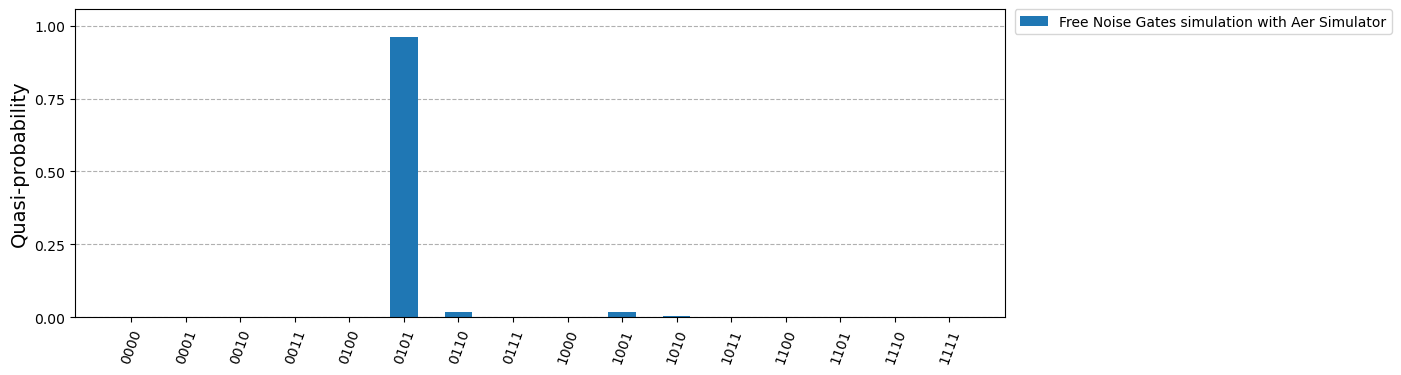

In [183]:
plot_histogram(probs_free_ander_min_noisefree_uccsd, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])

In [320]:
plot_histogram(probs_noise_aer_min_noisefree_uccsd, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])

{'1110': 179.0, '1111': 193.4, '0000': 181.3, '1101': 222.0, '0110': 887.6, '1000': 836.9, '1100': 181.6, '0011': 190.9, '0111': 908.1, '1011': 1061.7, '1001': 883.4, '0101': 1647.5, '1010': 1061.1, '0010': 186.5, '0100': 1162.8, '0001': 216.2}


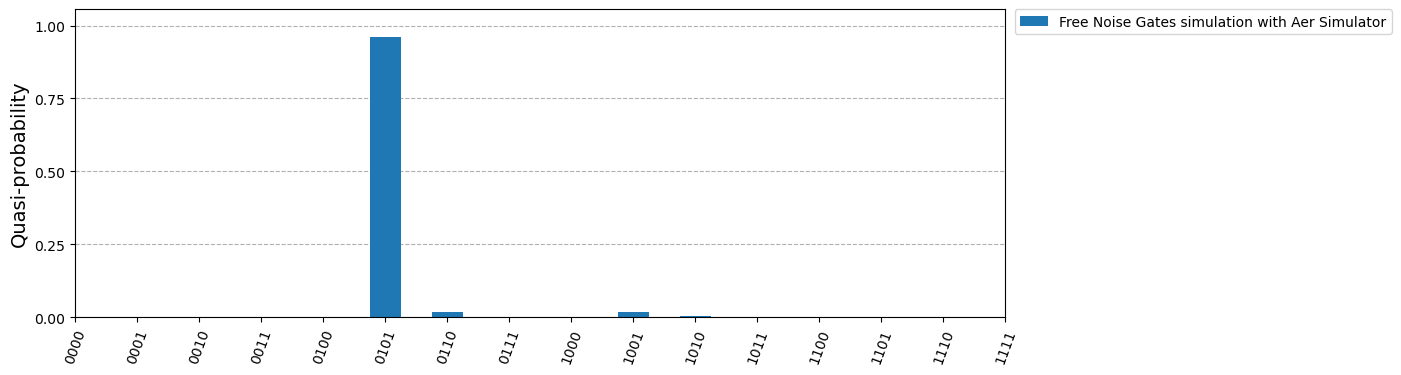

In [185]:
all_states = [''.join(state) for state in product('01', repeat=4)]

total_counts = sum(probs_free_aer_min_noisefree_uccsd.values())

probs_full = {state: probs_free_aer_min_noisefree_uccsd.get(state, 0) for state in all_states}
quasi_probs_original = {state: count / total_counts for state, count in probs_full.items()}

probs_free_aer_min_noisefree_uccsd = quasi_probs_original
plot_histogram(probs_free_aer_min_noisefree_uccsd, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])



Mean for UCCSD and Mr Anderson after noisless VQE: 7.3536575441553325
Variance for UCCSD and Mr Anderson after noisless VQE: 11.300536492314766
Standard deviation for UCCSD and Mr Anderson after noisless VQE: 3.3616270602663176
Mean for UCCSD and Mr Anderson after noisless VQE for each bit: [0.47087288 0.52617801 0.46577933 0.55040381]

Mean for UCCSD and Qiskit Aer after noisless VQE: 7.31406
Variance for UCCSD and Qiskit Aer after noisless VQE: 10.5928463164
Standard deviation for UCCSD and Qiskit Aer after noisless VQE: 3.254665315573938
Mean for UCCSD and Qiskit Aer after noisless VQE for each bit: [0.46191 0.5382  0.46683 0.53232]

For ideal simulations:
Mean for UCCSD and Mr Anderson after noisless VQE: 5.104415028275478
Variance for UCCSD and Mr Anderson after noisless VQE: 0.36565440883164124
Standard deviation for UCCSD and Mr Anderson after noisless VQE: 0.6046936487442557
Mean for UCCSD and Mr Anderson after noisless VQE for each bit: [0.02089368 0.97910632 0.02084029 0.9791

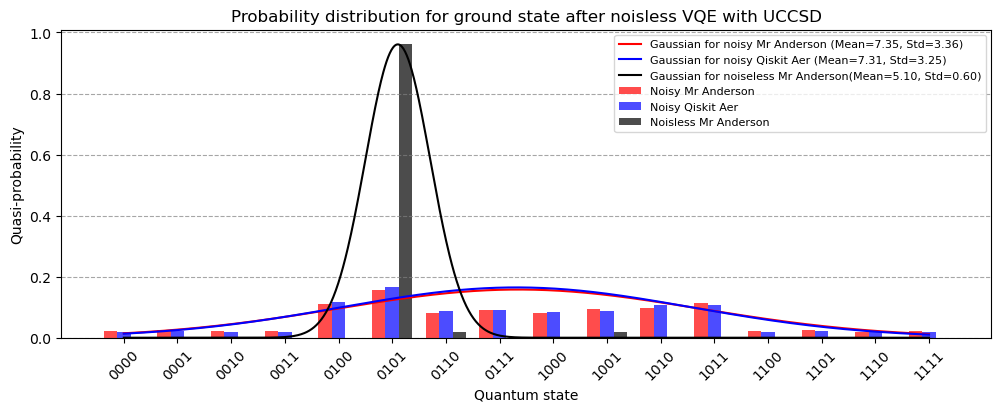

In [396]:
from scipy.stats import norm

# Noisless VQE and noisy UCCSD Mr Anderson 
states_as_integers = [int(state, 2) for state in probs_noise_ander_min_noisefree_uccsd.keys()]
probabilities_noise_ander_min_noisefree_uccsd = np.array(list(probs_noise_ander_min_noisefree_uccsd.values()))
mean_noise_ander_min_noisefree_uccsd = np.sum(np.array(states_as_integers) * probabilities_noise_ander_min_noisefree_uccsd)
variance_noise_ander_min_noisefree_uccsd = np.sum(probabilities_noise_ander_min_noisefree_uccsd * (np.array(states_as_integers) - mean_noise_ander_min_noisefree_uccsd)**2)
print(f"Mean for UCCSD and Mr Anderson after noisless VQE: {mean_noise_ander_min_noisefree_uccsd}")
print(f"Variance for UCCSD and Mr Anderson after noisless VQE: {variance_noise_ander_min_noisefree_uccsd}")

squared_diff = np.sum((np.arange(16) - mean_noise_ander_min_noisefree_uccsd) ** 2 * np.array(np.array(list(probs_noise_ander_min_noisefree_uccsd.values()))))  
sigma_noise_ander_min_noisefree_uccsd = np.sqrt(squared_diff)
print(f"Standard deviation for UCCSD and Mr Anderson after noisless VQE: {sigma_noise_ander_min_noisefree_uccsd}")

x = np.linspace(0, 15, 1000)  
gaussian_noise_ander_min_noisefree_uccsd = norm.pdf(x, mean_noise_ander_min_noisefree_uccsd , sigma_noise_ander_min_noisefree_uccsd)  
max_gaussian_value = max(gaussian_noise_ander_min_noisefree_uccsd)  
gaussian_noise_ander_min_noisefree_uccsd = gaussian_noise_ander_min_noisefree_uccsd / max_gaussian_value * max(probs_noise_ander_min_noisefree_uccsd.values()) 


bit_vectors = np.array([[int(bit) for bit in state] for state in probs_noise_ander_min_noisefree_uccsd.keys()])  # Estados como vectores binarios
mean_bits_noise_ander_min_noisefree_uccsd = np.sum(probabilities_noise_ander_min_noisefree_uccsd[:, None] * bit_vectors, axis=0)
print(f"Mean for UCCSD and Mr Anderson after noisless VQE for each bit: {mean_bits_noise_ander_min_noisefree_uccsd}")


# Noisless VQE and noisy UCCSD Qiskit Aer 
print()
probs_noise_aer_min_noisefree_uccsd = dict(sorted(probs_noise_aer_min_noisefree_uccsd.items()))

total_counts = sum(probs_noise_aer_min_noisefree_uccsd.values())
probs_noise_aer_min_noisefree_uccsd = {state: count / total_counts for state, count in probs_noise_aer_min_noisefree_uccsd.items()}

states_as_integers = [int(state, 2) for state in probs_noise_aer_min_noisefree_uccsd.keys()]
probabilities_noise_aer_min_noisefree_uccsd = np.array(list(probs_noise_aer_min_noisefree_uccsd.values()))
mean_noise_aer_min_noisefree_uccsd = np.sum(np.array(states_as_integers) * probabilities_noise_aer_min_noisefree_uccsd)
variance_noise_aer_min_noisefree_uccsd = np.sum(probabilities_noise_aer_min_noisefree_uccsd * (np.array(states_as_integers) - mean_noise_aer_min_noisefree_uccsd)**2)
print(f"Mean for UCCSD and Qiskit Aer after noisless VQE: {mean_noise_aer_min_noisefree_uccsd}")
print(f"Variance for UCCSD and Qiskit Aer after noisless VQE: {variance_noise_aer_min_noisefree_uccsd}")

squared_diff = np.sum((np.arange(16) - mean_noise_aer_min_noisefree_uccsd) ** 2 * np.array(probabilities_noise_aer_min_noisefree_uccsd))  
sigma_noise_aer_min_noisefree_uccsd = np.sqrt(squared_diff)
print(f"Standard deviation for UCCSD and Qiskit Aer after noisless VQE: {sigma_noise_aer_min_noisefree_uccsd}")

x = np.linspace(0, 15, 1000)  
gaussian_noise_aer_min_noisefree_uccsd = norm.pdf(x, mean_noise_aer_min_noisefree_uccsd , sigma_noise_aer_min_noisefree_uccsd)  
max_gaussian_value = max(gaussian_noise_aer_min_noisefree_uccsd)  
gaussian_noise_aer_min_noisefree_uccsd = gaussian_noise_aer_min_noisefree_uccsd / max_gaussian_value * max(probs_noise_aer_min_noisefree_uccsd.values()) 


bit_vectors = np.array([[int(bit) for bit in state] for state in probs_noise_aer_min_noisefree_uccsd.keys()])  # Estados como vectores binarios
mean_bits_noise_aer_min_noisefree_uccsd = np.sum(probabilities_noise_aer_min_noisefree_uccsd[:, None] * bit_vectors, axis=0)
print(f"Mean for UCCSD and Qiskit Aer after noisless VQE for each bit: {mean_bits_noise_aer_min_noisefree_uccsd}")



# Noisless VQE and noisless UCCSD Mr Anderson 
print()
print('For ideal simulations:')
states_as_integers = [int(state, 2) for state in probs_free_ander_min_noisefree_uccsd.keys()]
probabilities_free_ander_min_noisefree_uccsd = np.array(list(probs_free_ander_min_noisefree_uccsd.values()))
mean_free_ander_min_noisefree_uccsd = np.sum(np.array(states_as_integers) * probabilities_free_ander_min_noisefree_uccsd)
variance_free_ander_min_noisefree_uccsd = np.sum(probabilities_free_ander_min_noisefree_uccsd * (np.array(states_as_integers) - mean_free_ander_min_noisefree_uccsd)**2)
print(f"Mean for UCCSD and Mr Anderson after noisless VQE: {mean_free_ander_min_noisefree_uccsd}")
print(f"Variance for UCCSD and Mr Anderson after noisless VQE: {variance_free_ander_min_noisefree_uccsd}")

squared_diff = np.sum((np.arange(16) - mean_free_ander_min_noisefree_uccsd) ** 2 * np.array(np.array(list(probs_free_ander_min_noisefree_uccsd.values()))))  
sigma_free_ander_min_noisefree_uccsd = np.sqrt(squared_diff)
print(f"Standard deviation for UCCSD and Mr Anderson after noisless VQE: {sigma_free_ander_min_noisefree_uccsd}")

x = np.linspace(0, 15, 1000)  
gaussian_free_ander_min_noisefree_uccsd = norm.pdf(x, mean_free_ander_min_noisefree_uccsd , sigma_free_ander_min_noisefree_uccsd)  
max_gaussian_value = max(gaussian_free_ander_min_noisefree_uccsd)  
gaussian_free_ander_min_noisefree_uccsd = gaussian_free_ander_min_noisefree_uccsd / max_gaussian_value * max(probs_free_ander_min_noisefree_uccsd.values()) 


bit_vectors = np.array([[int(bit) for bit in state] for state in probs_free_ander_min_noisefree_uccsd.keys()])  # Estados como vectores binarios
mean_bits_free_ander_min_noisefree_uccsd = np.sum(probabilities_free_ander_min_noisefree_uccsd[:, None] * bit_vectors, axis=0)
print(f"Mean for UCCSD and Mr Anderson after noisless VQE for each bit: {mean_bits_free_ander_min_noisefree_uccsd}")


states = list(probs_noise_aer_min_noisefree_uccsd.keys())
states.sort()
x_pos = np.arange(len(states))  # Posiciones en el eje x para cada estado
bar_width = 0.25
fig, ax = plt.subplots()
ax.bar(x_pos - bar_width, probabilities_noise_ander_min_noisefree_uccsd,  width=bar_width, color='red', alpha=0.7, label="Noisy Mr Anderson")
ax.bar(x_pos , probabilities_noise_aer_min_noisefree_uccsd, width=bar_width, color='blue', alpha=0.7, label="Noisy Qiskit Aer")
ax.bar(x_pos + bar_width, probabilities_free_ander_min_noisefree_uccsd, width=bar_width, color='black', alpha=0.7, label="Noisless Mr Anderson")

ax.plot(x, gaussian_noise_ander_min_noisefree_uccsd, 'r-', label=f'Gaussian for noisy Mr Anderson (Mean={mean_noise_ander_min_noisefree_uccsd:.2f}, Std={sigma_noise_ander_min_noisefree_uccsd:.2f})')
ax.plot(x, gaussian_noise_aer_min_noisefree_uccsd, 'b-', label=f'Gaussian for noisy Qiskit Aer (Mean={mean_noise_aer_min_noisefree_uccsd:.2f}, Std={sigma_noise_aer_min_noisefree_uccsd:.2f})')
ax.plot(x, gaussian_free_ander_min_noisefree_uccsd, 'k-', label=f'Gaussian for noiseless Mr Anderson(Mean={mean_free_ander_min_noisefree_uccsd:.2f}, Std={sigma_free_ander_min_noisefree_uccsd:.2f})')

ax.set_xlabel('Quantum state')
ax.set_ylabel('Quasi-probability')
ax.set_title('Probability distribution for ground state after noisless VQE with UCCSD')
ax.legend(loc='upper right', fontsize=8)
plt.xticks(x_pos, states, rotation=45)
plt.grid(axis='y', linestyle='--', color='gray', alpha=0.7)
plt.savefig('histograma_noisfreevqe_uccsd_with_ideal')
plt.show()





In [236]:
probs_to_plot = [probs_noise_ander_min_noisefree_uccsd, probs_free_ander_min_noisefree_uccsd, probs_noise_aer_min_noisefree_uccsd]

legend = ['Mr Anderson','Noisless','Qiskit']
title = 'Probability distribution for ground state after noisless VQE with UCCSD'
filename = 'histo_noisefree_ucccsd'

plot_histogram(probs_to_plot, bar_labels=False, legend=legend, title=title, filename=filename, figsize=(17,7) )

Averaged groundstate energy (Hartree units): -0.9453794833780285


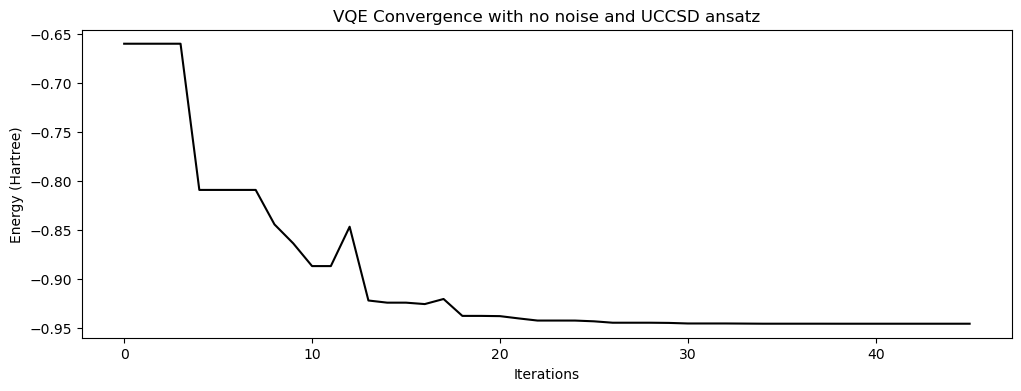

In [216]:
counts_noisefree_uccsd = np.arange(0, max_evaluations_noisefree_uccsd)
pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts_noisefree_uccsd, average_values_noisefree_uccsd, label="Average Energy", color="black")
pylab.xlabel("Iterations")
pylab.ylabel("Energy (Hartree)")
pylab.title("VQE Convergence with no noise and UCCSD ansatz")
pylab.savefig('vqe_noisfree_uccsd_avg_try')

print("Averaged groundstate energy (Hartree units):", average_values_noisefree_uccsd[-1])


In [217]:
#import seaborn as sns
#sns.violinplot(x="Realization", y="Energy",data= average_values_noisefree_uccsd)
#plt.show()


In [32]:
backend_fake = FakeKyiv()
noise_model = NoiseModel.from_backend(backend_fake)
noisy_estimator =  AerEstimator(backend_options={
        "noise_model": noise_model,
    },)

In [35]:

#average_values_noise_uccsd, probs_noise_ander_min_noise_uccsd, probs_free_ander_min_noise_uccsd, probs_noise_aer_min_noise_uccsd, probs_free_aer_min_noise_uccsd, max_evaluations_noise_uccsd = run_vqe_with_averaging(ansatz_uccsd, noisy_estimator, mapper, es_problem, n_repeats=50, maxiter=100, is_tUPS=False)


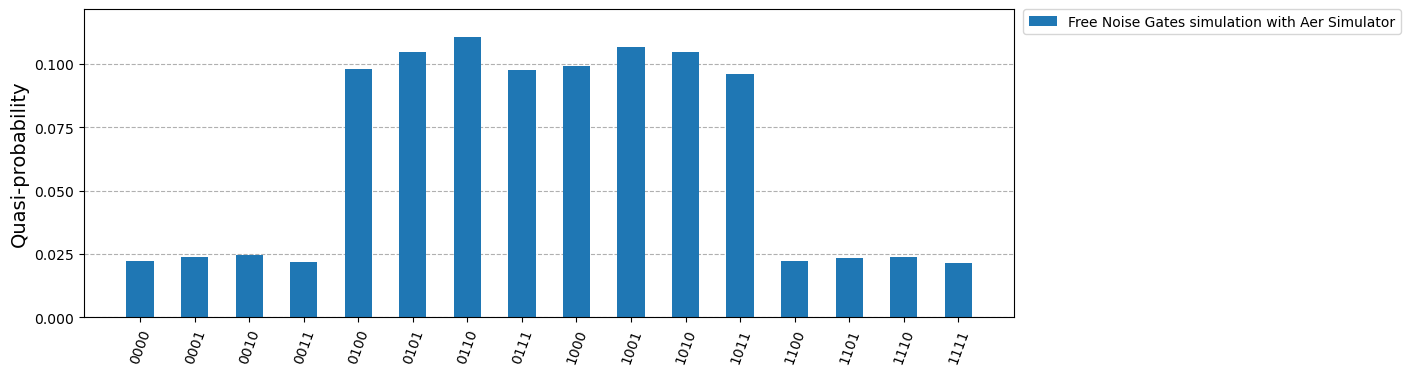

In [187]:
plot_histogram(probs_noise_ander_min_noise_uccsd, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])

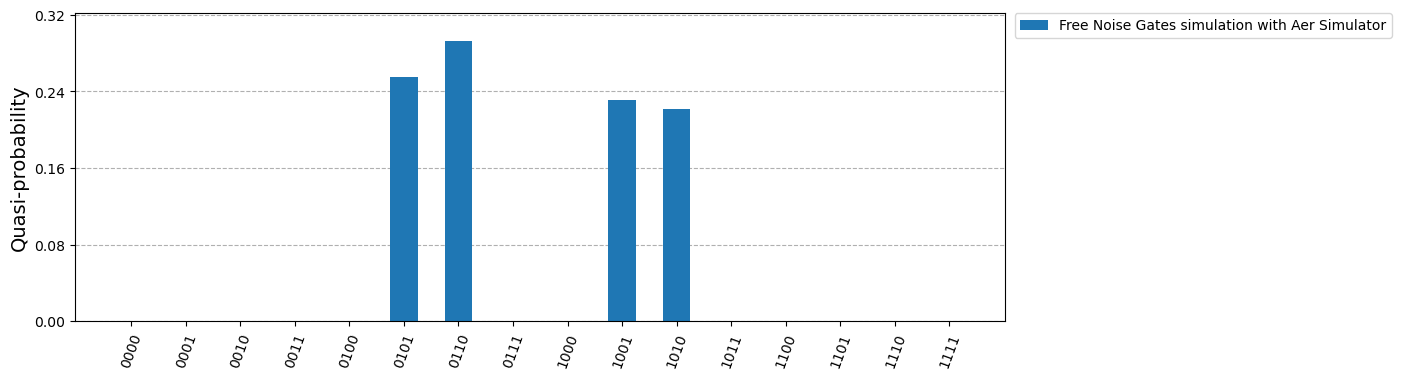

In [188]:
plot_histogram(probs_free_ander_min_noise_uccsd, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])

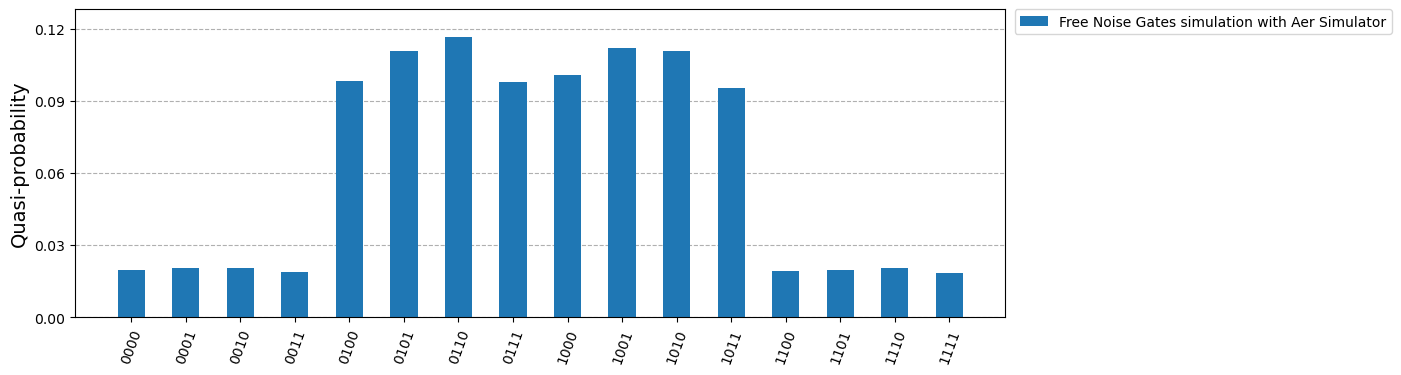

In [189]:
plot_histogram(probs_noise_aer_min_noise_uccsd, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])

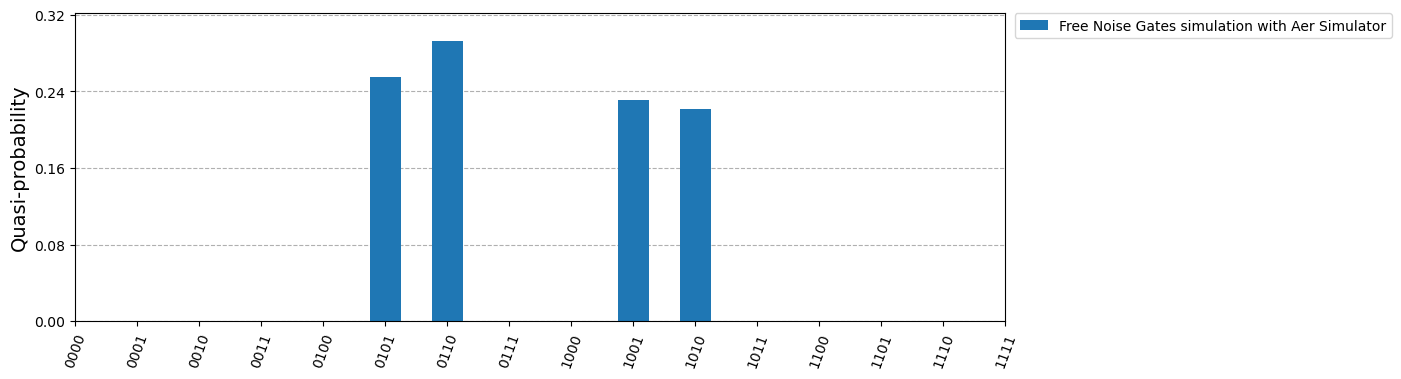

In [190]:
all_states = [''.join(state) for state in product('01', repeat=4)]

total_counts = sum(probs_free_aer_min_noise_uccsd.values())

probs_full = {state: probs_free_aer_min_noise_uccsd.get(state, 0) for state in all_states}
quasi_probs_original = {state: count / total_counts for state, count in probs_full.items()}

probs_free_aer_min_noise_uccsd = quasi_probs_original

plot_histogram(probs_free_aer_min_noise_uccsd, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])

Mean for UCCSD and Mr Anderson after noisy VQE: 7.478624448490823
Variance for UCCSD and Mr Anderson after noisy VQE: 11.002167122209949
Standard deviation for UCCSD and Mr Anderson after noisy VQE: 3.3169514802315017
Mean for UCCSD and Mr Anderson after noisy VQE for each bit: [0.49717025 0.50128555 0.50049042 0.49513939]

Mean for UCCSD and Qiskit Aer after noisy VQE: 7.471004
Variance for UCCSD and Qiskit Aer after noisy VQE: 10.169611231984
Standard deviation for UCCSD and Qiskit Aer after noisy VQE: 3.1889827895402636
Mean for UCCSD and Qiskit Aer after noisy VQE for each bit: [0.496866 0.501126 0.498842 0.493888]

For ideal simulation:
Mean for UCCSD and Mr Anderson after noisy VQE: 7.324023027122533
Variance for UCCSD and Mr Anderson after noisy VQE: 4.126337103224667
Standard deviation for UCCSD and Mr Anderson after noisy VQE: 2.0313387465473767
Mean for UCCSD and Mr Anderson after noisy VQE for each bit: [0.45242995 0.54757005 0.51430321 0.48569679]


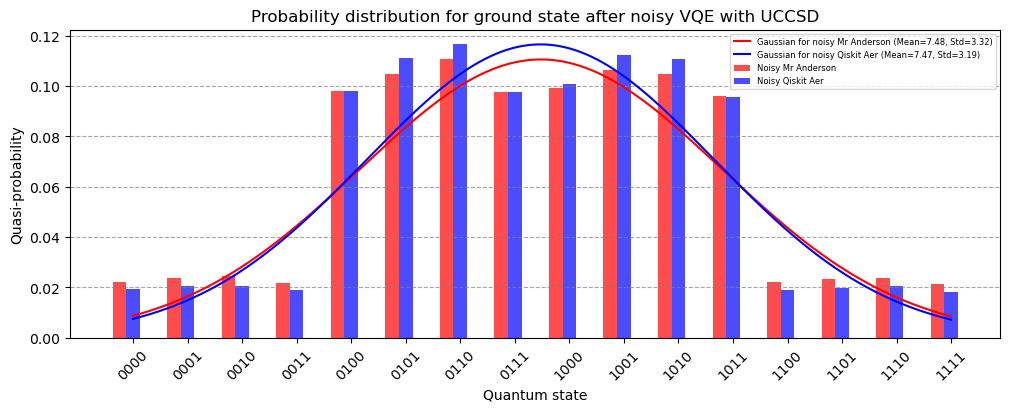

In [397]:
from scipy.stats import norm

# Noisy VQE and noisy UCCSD Mr Anderson 
states_as_integers = [int(state, 2) for state in probs_noise_ander_min_noise_uccsd.keys()]
probabilities_noise_ander_min_noise_uccsd = np.array(list(probs_noise_ander_min_noise_uccsd.values()))
mean_noise_ander_min_noise_uccsd = np.sum(np.array(states_as_integers) * probabilities_noise_ander_min_noise_uccsd)
variance_noise_ander_min_noise_uccsd = np.sum(probabilities_noise_ander_min_noise_uccsd * (np.array(states_as_integers) - mean_noise_ander_min_noise_uccsd)**2)
print(f"Mean for UCCSD and Mr Anderson after noisy VQE: {mean_noise_ander_min_noise_uccsd}")
print(f"Variance for UCCSD and Mr Anderson after noisy VQE: {variance_noise_ander_min_noise_uccsd}")

squared_diff = np.sum((np.arange(16) - mean_noise_ander_min_noise_uccsd) ** 2 * np.array(np.array(list(probs_noise_ander_min_noise_uccsd.values()))))  
sigma_noise_ander_min_noise_uccsd = np.sqrt(squared_diff)
print(f"Standard deviation for UCCSD and Mr Anderson after noisy VQE: {sigma_noise_ander_min_noise_uccsd}")

x = np.linspace(0, 15, 1000)  
gaussian_noise_ander_min_noise_uccsd = norm.pdf(x, mean_noise_ander_min_noise_uccsd , sigma_noise_ander_min_noise_uccsd)  
max_gaussian_value = max(gaussian_noise_ander_min_noise_uccsd)  
gaussian_noise_ander_min_noise_uccsd = gaussian_noise_ander_min_noise_uccsd / max_gaussian_value * max(probs_noise_ander_min_noise_uccsd.values()) 


bit_vectors = np.array([[int(bit) for bit in state] for state in probs_noise_ander_min_noise_uccsd.keys()])  # Estados como vectores binarios
mean_bits_noise_ander_min_noise_uccsd = np.sum(probabilities_noise_ander_min_noise_uccsd[:, None] * bit_vectors, axis=0)
print(f"Mean for UCCSD and Mr Anderson after noisy VQE for each bit: {mean_bits_noise_ander_min_noise_uccsd}")



# Noisy VQE and noisy UCCSD Qiskit Aer 
print()
probs_noise_aer_min_noise_uccsd = dict(sorted(probs_noise_aer_min_noise_uccsd.items()))

total_counts = sum(probs_noise_aer_min_noise_uccsd.values())
probs_noise_aer_min_noise_uccsd = {state: count / total_counts for state, count in probs_noise_aer_min_noise_uccsd.items()}

states_as_integers = [int(state, 2) for state in probs_noise_aer_min_noise_uccsd.keys()]
probabilities_noise_aer_min_noise_uccsd = np.array(list(probs_noise_aer_min_noise_uccsd.values()))
mean_noise_aer_min_noise_uccsd = np.sum(np.array(states_as_integers) * probabilities_noise_aer_min_noise_uccsd)
variance_noise_aer_min_noise_uccsd = np.sum(probabilities_noise_aer_min_noise_uccsd * (np.array(states_as_integers) - mean_noise_aer_min_noise_uccsd)**2)
print(f"Mean for UCCSD and Qiskit Aer after noisy VQE: {mean_noise_aer_min_noise_uccsd}")
print(f"Variance for UCCSD and Qiskit Aer after noisy VQE: {variance_noise_aer_min_noise_uccsd}")

squared_diff = np.sum((np.arange(16) - mean_noise_aer_min_noise_uccsd) ** 2 * np.array(probabilities_noise_aer_min_noise_uccsd))  
sigma_noise_aer_min_noise_uccsd = np.sqrt(squared_diff)
print(f"Standard deviation for UCCSD and Qiskit Aer after noisy VQE: {sigma_noise_aer_min_noise_uccsd}")

x = np.linspace(0, 15, 1000)  
gaussian_noise_aer_min_noise_uccsd = norm.pdf(x, mean_noise_aer_min_noise_uccsd , sigma_noise_aer_min_noise_uccsd)  
max_gaussian_value = max(gaussian_noise_aer_min_noise_uccsd)  
gaussian_noise_aer_min_noise_uccsd = gaussian_noise_aer_min_noise_uccsd / max_gaussian_value * max(probs_noise_aer_min_noise_uccsd.values()) 


bit_vectors = np.array([[int(bit) for bit in state] for state in probs_noise_aer_min_noise_uccsd.keys()])  # Estados como vectores binarios
mean_bits_noise_aer_min_noise_uccsd = np.sum(probabilities_noise_aer_min_noise_uccsd[:, None] * bit_vectors, axis=0)
print(f"Mean for UCCSD and Qiskit Aer after noisy VQE for each bit: {mean_bits_noise_aer_min_noise_uccsd}")



# Noisy VQE and noisless UCCSD Mr Anderson 
print()
print('For ideal simulation:')
states_as_integers = [int(state, 2) for state in probs_free_ander_min_noise_uccsd.keys()]
probabilities_free_ander_min_noise_uccsd = np.array(list(probs_free_ander_min_noise_uccsd.values()))
mean_free_ander_min_noise_uccsd = np.sum(np.array(states_as_integers) * probabilities_free_ander_min_noise_uccsd)
variance_free_ander_min_noise_uccsd = np.sum(probabilities_free_ander_min_noise_uccsd * (np.array(states_as_integers) - mean_free_ander_min_noise_uccsd)**2)
print(f"Mean for UCCSD and Mr Anderson after noisy VQE: {mean_free_ander_min_noise_uccsd}")
print(f"Variance for UCCSD and Mr Anderson after noisy VQE: {variance_free_ander_min_noise_uccsd}")

squared_diff = np.sum((np.arange(16) - mean_free_ander_min_noise_uccsd) ** 2 * np.array(np.array(list(probs_free_ander_min_noise_uccsd.values()))))  
sigma_free_ander_min_noise_uccsd = np.sqrt(squared_diff)
print(f"Standard deviation for UCCSD and Mr Anderson after noisy VQE: {sigma_free_ander_min_noise_uccsd}")

x = np.linspace(0, 15, 1000)  
gaussian_free_ander_min_noise_uccsd = norm.pdf(x, mean_free_ander_min_noise_uccsd , sigma_free_ander_min_noise_uccsd)  
max_gaussian_value = max(gaussian_free_ander_min_noise_uccsd)  
gaussian_free_ander_min_noise_uccsd = gaussian_free_ander_min_noise_uccsd / max_gaussian_value * max(probs_free_ander_min_noise_uccsd.values()) 


bit_vectors = np.array([[int(bit) for bit in state] for state in probs_free_ander_min_noise_uccsd.keys()])  # Estados como vectores binarios
mean_bits_free_ander_min_noise_uccsd = np.sum(probabilities_free_ander_min_noise_uccsd[:, None] * bit_vectors, axis=0)
print(f"Mean for UCCSD and Mr Anderson after noisy VQE for each bit: {mean_bits_free_ander_min_noise_uccsd}")


states = list(probs_noise_aer_min_noise_uccsd.keys())
states.sort()
x_pos = np.arange(len(states))  # Posiciones en el eje x para cada estado
bar_width = 0.25
fig, ax = plt.subplots()
ax.bar(x_pos - bar_width, probabilities_noise_ander_min_noise_uccsd,  width=bar_width, color='red', alpha=0.7, label="Noisy Mr Anderson")
ax.bar(x_pos , probabilities_noise_aer_min_noise_uccsd, width=bar_width, color='blue', alpha=0.7, label="Noisy Qiskit Aer")
#ax.bar(x_pos + bar_width, probabilities_free_ander_min_noise_uccsd, width=bar_width, color='black', alpha=0.7, label="Noisless Mr Anderson")

ax.plot(x, gaussian_noise_ander_min_noise_uccsd, 'r-', label=f'Gaussian for noisy Mr Anderson (Mean={mean_noise_ander_min_noise_uccsd:.2f}, Std={sigma_noise_ander_min_noise_uccsd:.2f})')
ax.plot(x, gaussian_noise_aer_min_noise_uccsd, 'b-', label=f'Gaussian for noisy Qiskit Aer (Mean={mean_noise_aer_min_noise_uccsd:.2f}, Std={sigma_noise_aer_min_noise_uccsd:.2f})')
#ax.plot(x, gaussian_free_ander_min_noise_uccsd, 'k-', label=f'Gaussian for noiseless Mr Anderson(Mean={mean_free_ander_min_noise_uccsd:.2f}, Std={sigma_free_ander_min_noise_uccsd:.2f})')

ax.set_xlabel('Quantum state')
ax.set_ylabel('Quasi-probability')
ax.set_title('Probability distribution for ground state after noisy VQE with UCCSD')
ax.legend(loc='upper right',fontsize=6)
plt.xticks(x_pos, states, rotation=45)
plt.grid(axis='y', linestyle='--', color='gray', alpha=0.7)
plt.savefig('histograma_noisyvqe_uccsd_without_ideal')
plt.show()

In [80]:
probs_to_plot = [probs_noise_ander_min_noise_uccsd, probs_free_ander_min_noise_uccsd, probs_noise_aer_min_noise_uccsd]

legend = ['Mr Anderson','Noisless','Qiskit']
title = 'Probability distribution for ground state after noisy VQE with UCCSD'
filename = 'histo_noise_ucccsd'

plot_histogram(probs_to_plot, bar_labels=False, legend=legend, title=title, filename=filename, figsize=(17,7) )

Averaged groundstate energy (Hartree units): -0.6229476224236427


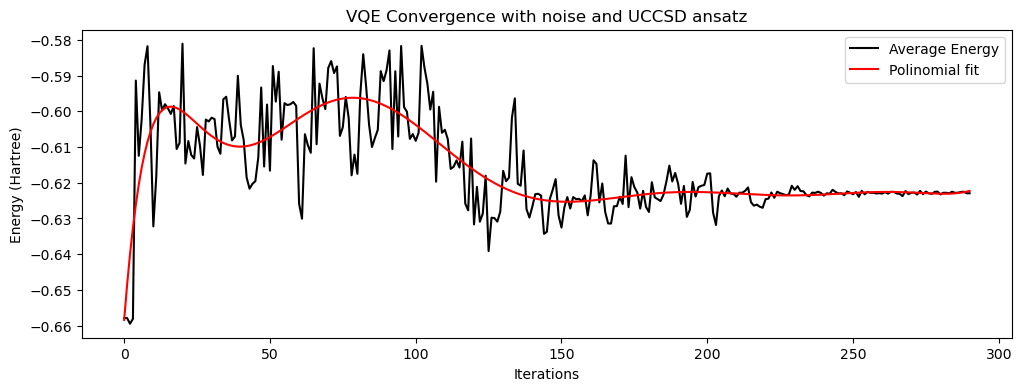

In [213]:
counts_noise_uccsd = np.arange(0, max_evaluations_noise_uccsd)

coeffs = Polynomial.fit(counts_noise_uccsd, average_values_noise_uccsd, deg=10)
poly_fit = coeffs(counts_noise_uccsd)


pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts_noise_uccsd, average_values_noise_uccsd, label="Average Energy", color="black")
plt.plot(counts_noise_uccsd, poly_fit, color='red', label='Polinomial fit', linewidth=1.5)
pylab.xlabel("Iterations")
pylab.ylabel("Energy (Hartree)")
pylab.title("VQE Convergence with noise and UCCSD ansatz")
pylab.savefig('vqe_noise_uccsd_avg')
plt.legend()

print("Averaged groundstate energy (Hartree units):", average_values_noise_uccsd[-1])


##### WE DO THE SAME WITH tUPS


In [15]:
import qiskit_aer
from qiskit import QuantumCircuit
from qiskit.circuit.random import random_circuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeTorino
import pyscf
import numpy as np
from slowquant.qiskit_interface.wavefunction import WaveFunction
from slowquant.qiskit_interface.interface import QuantumInterface
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.primitives import Estimator
from qiskit.primitives import Sampler as Sampler
from qiskit.primitives import StatevectorSampler as SamplerV2

from qiskit_aer.primitives import Sampler as SamplerAer
from qiskit_aer.primitives import SamplerV2 as SamplerV2Aer

from qiskit_ibm_runtime import Sampler as SamplerIBM #outdated
from qiskit_ibm_runtime import SamplerV2 as SamplerV2IBM
from qiskit_aer import AerSimulator
aer = AerSimulator()

In [18]:
estimator = Estimator()
mapper = JordanWignerMapper()
QI = QuantumInterface(estimator,"tUPS", mapper, ansatz_options={"n_layers":2}) #too many layers increase the deepness of the circuit and vqe calculations will take too long
ansatz_tups = QI.construct_circuit(num_orbs=es_problem.num_spatial_orbitals, num_elec=es_problem.num_particles)
ansatz_tups = QI.circuit
ansatz_tups.decompose()
ansatz_tups.measure_all()
print(type(ansatz_tups))
#ansatz_tups.draw('mpl')
t_circ = transpile(
    ansatz_tups,
    backend_fake,
    initial_layout=linear_qubit_layout,
    seed_transpiler=10,
    scheduling_method='asap'
    )
print(len(t_circ.data))

Number of shots is None. Ideal simulator is assumed.
<class 'qiskit_nature.second_q.circuit.library.initial_states.hartree_fock.HartreeFock'>
830


/tmp/ipykernel_854/3459400470.py:1: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


In [132]:
backend_fake = FakeKyiv()
sim_noise_ander = MrAndersonSimulator(gates=standard_gates, CircuitClass=EfficientCircuit, parallel= False)
sim_free_ander = MrAndersonSimulator(gates=noise_free_gates, CircuitClass=EfficientCircuit, parallel= False)
sim_noise_aer = AerSimulator.from_backend(backend_fake)
sim_free_aer =AerSimulator()

n_qubit = 4
n_classic_bit = 4
linear_qubit_layout = [0,1,2,3] # linear layout
psi0 = [1] + [0] * (2**n_qubit-1) # starting state
shots = 100 # shots
device_param = DeviceParameters(linear_qubit_layout)
device_param.load_from_backend(backend_fake) # get parameters from the backend
device_param_lookup = device_param.__dict__() # get dict representation.

In [171]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit_aer.noise import NoiseModel

backend = FakeKyiv()
noise_model = NoiseModel.from_backend(backend)
coupling_map = backend.configuration().coupling_map
basis_gates = noise_model.basis_gates

backend = AerSimulator(noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates)


qubit_op = mapper.map(es_problem.second_q_ops()[0])  # Map second quantized Hamiltonian
n_qubits = qubit_op.num_qubits
ansatz_tups.remove_final_measurements() # we need this line, otherwise it'll not work

vqe_solver = VQE(Estimator(), ansatz_tups, SLSQP(maxiter=100))
vqe_solver.initial_point = np.random.rand(ansatz_tups.num_parameters)

        # Compute the ground state energy
result = vqe_solver.compute_minimum_eigenvalue(qubit_op)
      
vqe_result = vqe_solver._build_vqe_result(
    ansatz = vqe_solver.ansatz,
    optimizer_result = result.optimizer_result,
    aux_operators_evaluated = result.aux_operators_evaluated,
    optimizer_time = result.optimizer_time
    )

optimal_circuit = vqe_result.optimal_circuit
ansatz_circuit = optimal_circuit
ansatz_circuit = ansatz_circuit.decompose()  
ansatz_circuit.measure_all()

t_circ = transpile(
    ansatz_circuit,
    backend_fake,
    initial_layout=linear_qubit_layout,
    seed_transpiler=10,
    scheduling_method='asap'
    )


t_circ = t_circ.assign_parameters(vqe_result.optimal_parameters)

#result = backend.run([t_circ]).result()
#counts = result.get_counts(0)
#plot_histogram(counts)



#probability_dist_noisy_aer = sim_noise_aer.run(t_circ, shots=10000).result()


/tmp/ipykernel_568/3326028515.py:20: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE(Estimator(), ansatz_tups, SLSQP(maxiter=100))


0.15.1


In [19]:
ansatz_tups.remove_final_measurements() # we need this line, otherwise it'll not work

#average_values_noisefree_tups, probs_noise_ander_min_noisefree_tups, probs_free_ander_min_noisefree_tups, probs_noise_aer_min_noisefree_tups, probs_free_aer_min_noisefree_tups, max_evaluations_noisefree_tups = run_vqe_with_averaging(ansatz_tups, Estimator(), mapper, es_problem, n_repeats=100, maxiter=100, is_tUPS=True)


/tmp/ipykernel_568/3492561310.py:3: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  average_values_noisefree_tups, probs_noise_ander_min_noisefree_tups, probs_free_ander_min_noisefree_tups, probs_noise_aer_min_noisefree_tups, probs_free_aer_min_noisefree_tups, max_evaluations_noisefree_tups = run_vqe_with_averaging(ansatz_tups, Estimator(), mapper, es_problem, n_repeats=100, maxiter=100, is_tUPS=True)


Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansa

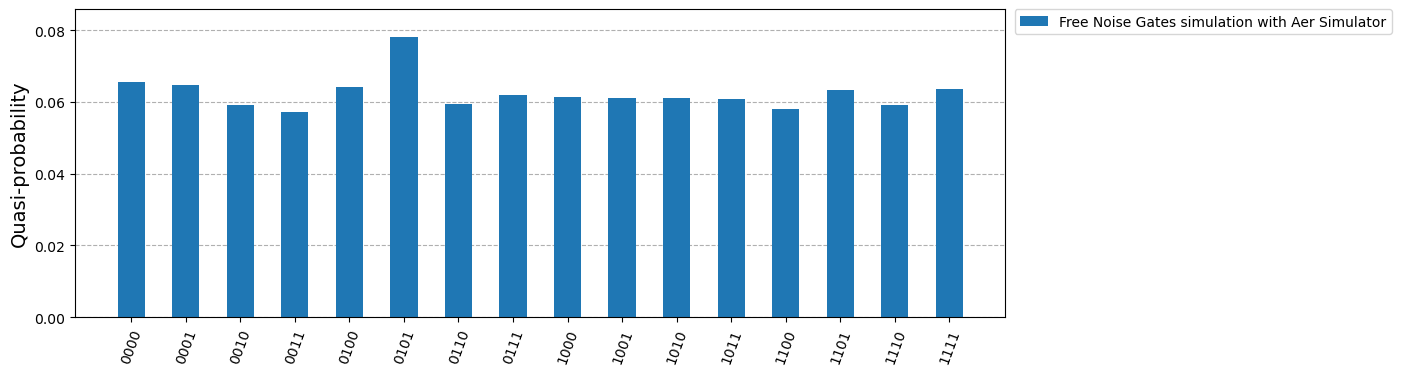

In [191]:
plot_histogram(probs_noise_ander_min_noisefree_tups, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])

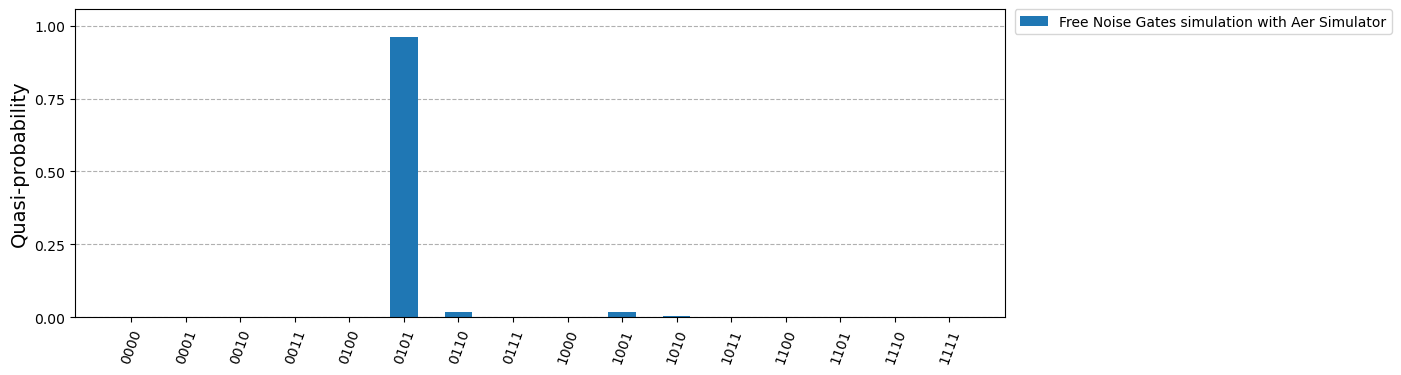

In [192]:
plot_histogram(probs_free_ander_min_noisefree_tups, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])

In [22]:
#plot_histogram(probs_noise_aer_min_noisefree_tups, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])

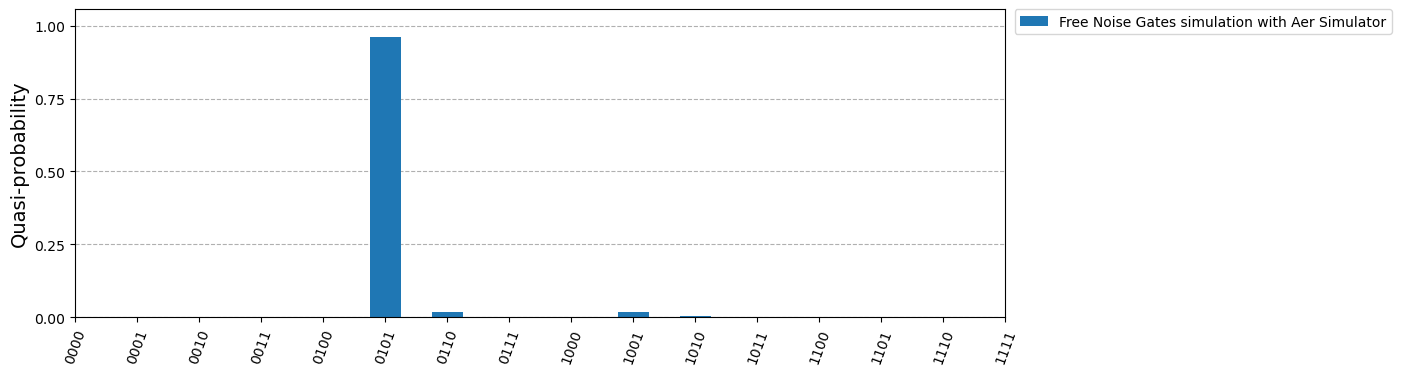

In [193]:
all_states = [''.join(state) for state in product('01', repeat=4)]

total_counts = sum(probs_free_aer_min_noisefree_tups.values())

probs_full = {state: probs_free_aer_min_noisefree_tups.get(state, 0) for state in all_states}
quasi_probs_original = {state: count / total_counts for state, count in probs_full.items()}

probs_free_aer_min_noisefree_tups = quasi_probs_original
plot_histogram(probs_free_aer_min_noisefree_tups, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])

Mean for tUPS and Mr Anderson after noiseless VQE: 7.422948351563368
Variance for tUPS and Mr Anderson after noiseless VQE: 21.263673493437654
Standard deviation for tUPS and Mr Anderson after noisless VQE: 4.611255088740771
Mean for tUPS and Mr Anderson after noiseless VQE for each bit: [0.4891168  0.5080562  0.48315339 0.51148235]

For ideal simulation:
Mean for tUPS and Mr Anderson after noisless VQE: 5.104324809674755
Variance for tUPS and Mr Anderson after noisless VQE: 0.36528555984106964
Standard deviation for tUPS and Mr Anderson after noisyless VQE: 0.60438858348009
Mean for tUPS and Mr Anderson after noiseless VQE for each bit: [0.02086496 0.97913504 0.02086496 0.97913504]


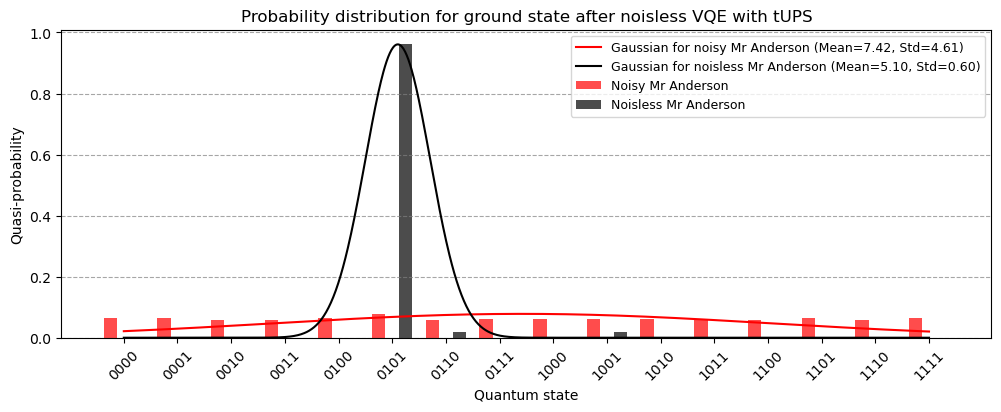

In [402]:
from scipy.stats import norm

# Noisless VQE and noisy tUPS Mr Anderson 
states_as_integers = [int(state, 2) for state in probs_noise_ander_min_noisefree_tups.keys()]
probabilities_noise_ander_min_noisefree_tups = np.array(list(probs_noise_ander_min_noisefree_tups.values()))
mean_noise_ander_min_noisefree_tups = np.sum(np.array(states_as_integers) * probabilities_noise_ander_min_noisefree_tups)
variance_noise_ander_min_noisefree_tups = np.sum(probabilities_noise_ander_min_noisefree_tups * (np.array(states_as_integers) - mean_noise_ander_min_noisefree_tups)**2)
print(f"Mean for tUPS and Mr Anderson after noiseless VQE: {mean_noise_ander_min_noisefree_tups}")
print(f"Variance for tUPS and Mr Anderson after noiseless VQE: {variance_noise_ander_min_noisefree_tups}")

squared_diff = np.sum((np.arange(16) - mean_noise_ander_min_noisefree_tups) ** 2 * np.array(np.array(list(probs_noise_ander_min_noisefree_tups.values()))))  
sigma_noise_ander_min_noisefree_tups = np.sqrt(squared_diff)
print(f"Standard deviation for tUPS and Mr Anderson after noisless VQE: {sigma_noise_ander_min_noisefree_tups}")

x = np.linspace(0, 15, 1000)  
gaussian_noise_ander_min_noisefree_tups = norm.pdf(x, mean_noise_ander_min_noisefree_tups , sigma_noise_ander_min_noisefree_tups)  
max_gaussian_value = max(gaussian_noise_ander_min_noisefree_tups)  
gaussian_noise_ander_min_noisefree_tups = gaussian_noise_ander_min_noisefree_tups / max_gaussian_value * max(probs_noise_ander_min_noisefree_tups.values()) 



bit_vectors = np.array([[int(bit) for bit in state] for state in probs_noise_ander_min_noisefree_tups.keys()])  
mean_bits_noise_ander_min_noisefree_tups = np.sum(probabilities_noise_ander_min_noisefree_tups[:, None] * bit_vectors, axis=0)
print(f"Mean for tUPS and Mr Anderson after noiseless VQE for each bit: {mean_bits_noise_ander_min_noisefree_tups}")



# Noisless VQE and noisy tUPS Qiskit Aer 
#print()
#probs_noise_aer_min_noisefree_tups = dict(sorted(probs_noise_aer_min_noisefree_tups.items()))
#total_counts = sum(probs_noise_aer_min_noisefree_tups.values())
#probs_noise_aer_min_noisefree_tups = {state: count / total_counts for state, count in probs_noise_aer_min_noisefree_tups.items()}#

#states_as_integers = [int(state, 2) for state in probs_noise_aer_min_noisefree_tups.keys()]
#probabilities_noise_aer_min_noisefree_tups = np.array(list(probs_noise_aer_min_noisefree_tups.values()))
#mean_noise_aer_min_noisefree_tups = np.sum(np.array(states_as_integers) * probabilities_noise_aer_min_noisefree_tups)
#variance_noise_aer_min_noisefree_tups = np.sum(probabilities_noise_aer_min_noisefree_tups * (np.array(states_as_integers) - mean_noise_aer_min_noisefree_tups)**2)
#print(f"Mean for tUPS and Qiskit Aer after noisless VQE: {mean_noise_aer_min_noisefree_tups}")
#print(f"Variance for tUPS and Qiskit Aer after noisless VQE: {variance_noise_aer_min_noisefree_tups}")

#squared_diff = np.sum((np.arange(16) - mean_noise_aer_min_noisefree_tups) ** 2 * np.array(probabilities_noise_aer_min_noisefree_tups))  
#sigma_noise_aer_min_noisefree_tups = np.sqrt(squared_diff)
#print(f"Standard deviation for tUPS and Qiskit Aer after noiseless VQE: {sigma_noise_aer_min_noisefree_tups}")

#x = np.linspace(0, 15, 1000)  
#gaussian_noise_aer_min_noisefree_tups = norm.pdf(x, mean_noise_aer_min_noisefree_tups , sigma_noise_aer_min_noisefree_tups)  
#max_gaussian_value = max(gaussian_noise_aer_min_noisefree_tups)  
#gaussian_noise_aer_min_noisefree_tups = gaussian_noise_aer_min_noise_tups / max_gaussian_value * max(probs_noise_aer_min_noisefree_tups.values()) 


#bit_vectors = np.array([[int(bit) for bit in state] for state in probs_noise_aer_min_noisefree_tups.keys()])  
#mean_bits_noise_aer_min_noisefree_tups = np.sum(probabilities_noise_aer_min_noisefree_tups[:, None] * bit_vectors, axis=0)
#print(f"Mean for tUPS and Mr Anderson after noiseless VQE for each bit: {mean_bits_noise_aer_min_noisefree_tups}")



# Noisless VQE and noisless UCCSD Mr Anderson 
print()
print('For ideal simulation:')
states_as_integers = [int(state, 2) for state in probs_free_ander_min_noisefree_tups.keys()]
probabilities_free_ander_min_noisefree_tups = np.array(list(probs_free_ander_min_noisefree_tups.values()))
mean_free_ander_min_noisefree_tups = np.sum(np.array(states_as_integers) * probabilities_free_ander_min_noisefree_tups)
variance_free_ander_min_noisefree_tups = np.sum(probabilities_free_ander_min_noisefree_tups * (np.array(states_as_integers) - mean_free_ander_min_noisefree_tups)**2)
print(f"Mean for tUPS and Mr Anderson after noisless VQE: {mean_free_ander_min_noisefree_tups}")
print(f"Variance for tUPS and Mr Anderson after noisless VQE: {variance_free_ander_min_noisefree_tups}")

squared_diff = np.sum((np.arange(16) - mean_free_ander_min_noisefree_tups) ** 2 * np.array(np.array(list(probs_free_ander_min_noisefree_tups.values()))))  
sigma_free_ander_min_noisefree_tups = np.sqrt(squared_diff)
print(f"Standard deviation for tUPS and Mr Anderson after noisyless VQE: {sigma_free_ander_min_noisefree_tups}")

x = np.linspace(0, 15, 1000)  
gaussian_free_ander_min_noisefree_tups = norm.pdf(x, mean_free_ander_min_noisefree_tups , sigma_free_ander_min_noisefree_uccsd)  
max_gaussian_value = max(gaussian_free_ander_min_noisefree_tups)  
gaussian_free_ander_min_noisefree_tups = gaussian_free_ander_min_noisefree_tups / max_gaussian_value * max(probs_free_ander_min_noisefree_tups.values()) 


bit_vectors = np.array([[int(bit) for bit in state] for state in probs_free_ander_min_noisefree_tups.keys()])  
mean_bits_free_ander_min_noisefree_tups = np.sum(probabilities_free_ander_min_noisefree_tups[:, None] * bit_vectors, axis=0)
print(f"Mean for tUPS and Mr Anderson after noiseless VQE for each bit: {mean_bits_free_ander_min_noisefree_tups}")


states = list(probs_free_ander_min_noisefree_tups.keys())
states.sort()
x_pos = np.arange(len(states))  # Posiciones en el eje x para cada estado
bar_width = 0.25
fig, ax = plt.subplots()

ax.bar(x_pos - bar_width, probabilities_noise_ander_min_noisefree_tups,  width=bar_width, color='red', alpha=0.7, label="Noisy Mr Anderson")
ax.plot(x, gaussian_noise_ander_min_noisefree_tups, 'r-', label=f'Gaussian for noisy Mr Anderson (Mean={mean_noise_ander_min_noisefree_tups:.2f}, Std={sigma_noise_ander_min_noisefree_tups:.2f})')

#ax.bar(x_pos , probabilities_noise_aer_min_noisefree_tups, width=bar_width, color='blue', alpha=0.7, label="Noisy Qiskit Aer")
#ax.plot(x, gaussian_noise_aer_min_noisefree_tups, 'b-', label=f'Gaussian for noisy Qiskit Aer (Mean={mean_noise_aer_min_noisefree_tups:.2f}, Std={sigma_noise_aer_min_noisefree_tups:.2f})')

ax.bar(x_pos + bar_width, probabilities_free_ander_min_noisefree_tups, width=bar_width, color='black', alpha=0.7, label="Noisless Mr Anderson")
ax.plot(x, gaussian_free_ander_min_noisefree_tups, 'k-', label=f'Gaussian for noisless Mr Anderson (Mean={mean_free_ander_min_noisefree_tups:.2f}, Std={sigma_free_ander_min_noisefree_tups:.2f})')

ax.set_xlabel('Quantum state')
ax.set_ylabel('Quasi-probability')
ax.set_title('Probability distribution for ground state after noisless VQE with tUPS')
ax.legend(loc='upper right',fontsize=9)
plt.xticks(x_pos, states, rotation=45)
plt.grid(axis='y', linestyle='--', color='gray', alpha=0.7)
#plt.figure(figsize=(10, 7))  # Cambia el tamaño a 10x5 pulgadas
plt.savefig('histograma_noisefreevqe_tups_with_ideal')
plt.show()

In [82]:
probs_to_plot = [probs_noise_ander_min_noisefree_tups, probs_free_ander_min_noisefree_uccsd]

legend = ['Mr Anderson','Noisless']
title = 'Probability distribution for ground state after noisless VQE with tUPS'
filename = 'histo_noisefree_tups'

plot_histogram(probs_to_plot, bar_labels=False, legend=legend, title=title, filename=filename, figsize=(17,7) )

Averaged groundstate energy (Hartree units): -0.9453794455125984


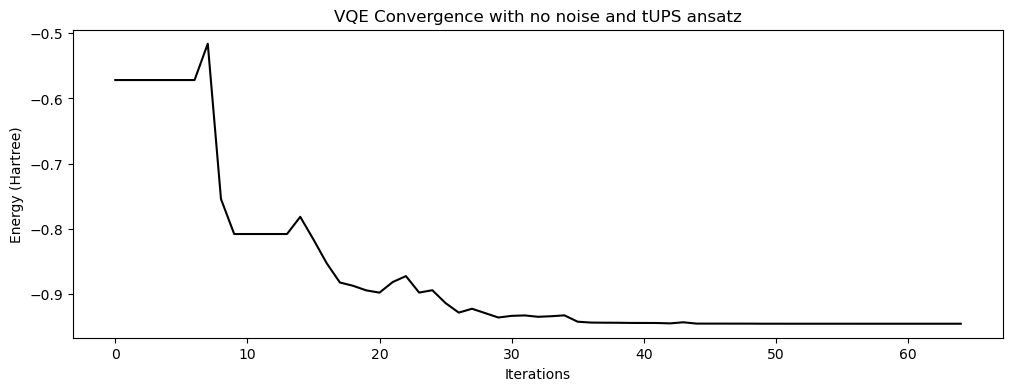

In [215]:
counts_noisefree_tups = np.arange(0, max_evaluations_noisefree_tups)
pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts_noisefree_tups, average_values_noisefree_tups, label="Average Energy", color="black")
pylab.xlabel("Iterations")
pylab.ylabel("Energy (Hartree)")
pylab.title("VQE Convergence with no noise and tUPS ansatz")
pylab.savefig('vqe_noisefree_tups_avg')

print("Averaged groundstate energy (Hartree units):", average_values_noisefree_tups[-1])


In [13]:
backend_fake = FakeKyiv()
noise_model = NoiseModel.from_backend(backend_fake)
noisy_estimator =  AerEstimator(backend_options={
        "noise_model": noise_model,
    },)

In [14]:
ansatz_tups.remove_final_measurements() # we need this line, otherwise it'll not work

#average_values_noise_tups, probs_noise_ander_min_noise_tups, probs_free_ander_min_noise_tups, probs_noise_aer_min_noise_tups, probs_free_aer_min_noise_tups, max_evaluations_noise_tups = run_vqe_with_averaging(ansatz_tups, noisy_estimator, mapper, es_problem, n_repeats=50, maxiter=100, is_tUPS=True)


Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansa

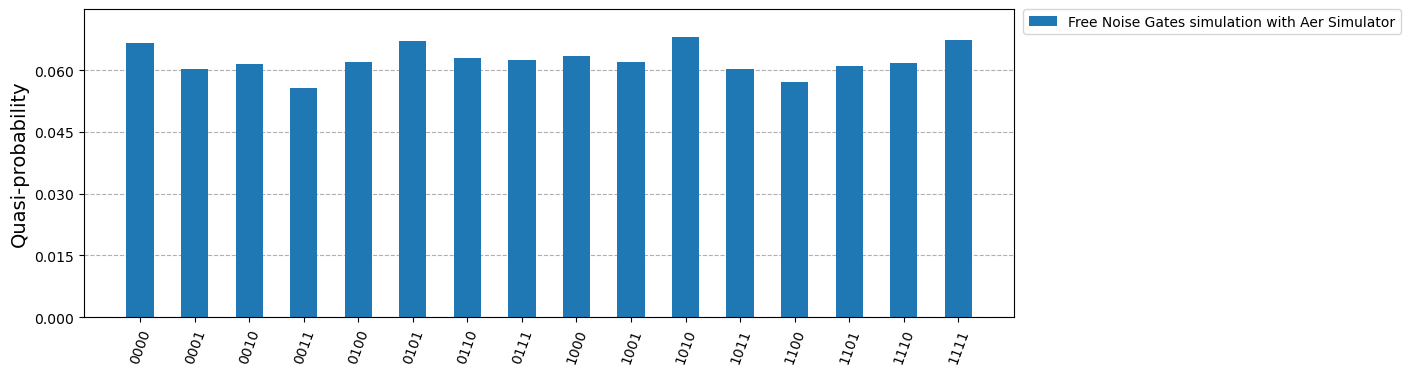

In [354]:
plot_histogram(probs_noise_ander_min_noise_tups, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])

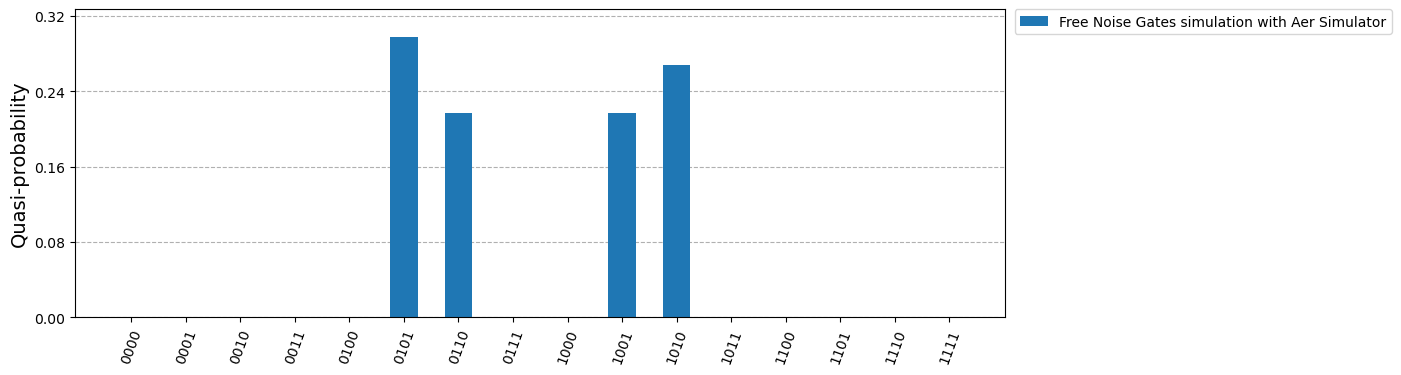

In [355]:
plot_histogram(probs_free_ander_min_noise_tups, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])

In [196]:
#plot_histogram(probs_noise_aer_min_noisefree_tups, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])

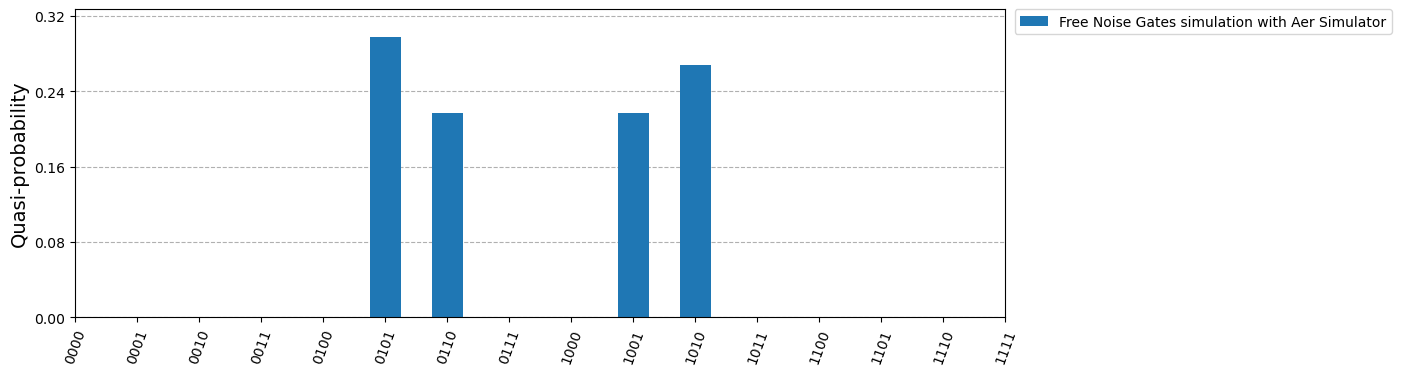

In [197]:
all_states = [''.join(state) for state in product('01', repeat=4)]

total_counts = sum(probs_free_aer_min_noise_tups.values())

probs_full = {state: probs_free_aer_min_noise_tups.get(state, 0) for state in all_states}
quasi_probs_original = {state: count / total_counts for state, count in probs_full.items()}

probs_free_aer_min_noise_tups = quasi_probs_original
plot_histogram(probs_free_aer_min_noise_tups, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])

Mean for tUPS and Mr Anderson after noisy VQE: 7.513664071623756
Variance for tUPS and Mr Anderson after noisy VQE: 21.34562941604341
Standard deviation for tUPS and Mr Anderson after noisy VQE: 4.620133051768467
Mean for tUPS and Mr Anderson after noisy VQE for each bit: [0.50116067 0.50195235 0.50018366 0.49620197]

For ideal simulation:
Mean for tUPS and Mr Anderson after noisy VQE: 7.425948105173623
Variance for tUPS and Mr Anderson after noisy VQE: 4.5070128102609335
Standard deviation for tUPS and Mr Anderson after noisy VQE: 2.1229726353066667
Mean for tUPS and Mr Anderson after noisy VQE for each bit: [0.48518962 0.51481038 0.48518962 0.51481038]


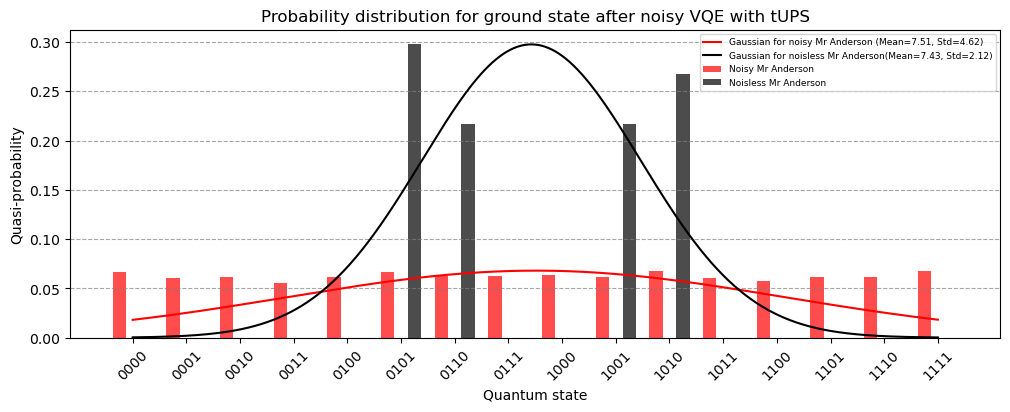

In [399]:
from scipy.stats import norm

# Noisy VQE and noisy tUPS Mr Anderson 
states_as_integers = [int(state, 2) for state in probs_noise_ander_min_noise_tups.keys()]
probabilities_noise_ander_min_noise_tups = np.array(list(probs_noise_ander_min_noise_tups.values()))
mean_noise_ander_min_noise_tups = np.sum(np.array(states_as_integers) * probabilities_noise_ander_min_noise_tups)
variance_noise_ander_min_noise_tups = np.sum(probabilities_noise_ander_min_noise_tups * (np.array(states_as_integers) - mean_noise_ander_min_noise_tups)**2)
print(f"Mean for tUPS and Mr Anderson after noisy VQE: {mean_noise_ander_min_noise_tups}")
print(f"Variance for tUPS and Mr Anderson after noisy VQE: {variance_noise_ander_min_noise_tups}")

squared_diff = np.sum((np.arange(16) - mean_noise_ander_min_noise_tups) ** 2 * np.array(np.array(list(probs_noise_ander_min_noise_tups.values()))))  
sigma_noise_ander_min_noise_tups = np.sqrt(squared_diff)
print(f"Standard deviation for tUPS and Mr Anderson after noisy VQE: {sigma_noise_ander_min_noise_tups}")

x = np.linspace(0, 15, 1000)  
gaussian_noise_ander_min_noise_tups = norm.pdf(x, mean_noise_ander_min_noise_tups , sigma_noise_ander_min_noise_tups)  
max_gaussian_value = max(gaussian_noise_ander_min_noise_tups)  
gaussian_noise_ander_min_noise_tups = gaussian_noise_ander_min_noise_tups / max_gaussian_value * max(probs_noise_ander_min_noise_tups.values()) 


bit_vectors = np.array([[int(bit) for bit in state] for state in probs_noise_ander_min_noise_tups.keys()])  
mean_bits_noise_ander_min_noise_tups = np.sum(probabilities_noise_ander_min_noise_tups[:, None] * bit_vectors, axis=0)
print(f"Mean for tUPS and Mr Anderson after noisy VQE for each bit: {mean_bits_noise_ander_min_noise_tups}")



# Noisy VQE and noisy tUPS Qiskit Aer 
#print()
#probs_noise_aer_min_noise_tups = dict(sorted(probs_noise_aer_min_noise_tups.items()))
#total_counts = sum(probs_noise_aer_min_noise_tups.values())
#probs_noise_aer_min_noise_tups = {state: count / total_counts for state, count in probs_noise_aer_min_noise_tups.items()}#

#states_as_integers = [int(state, 2) for state in probs_noise_aer_min_noise_tups.keys()]
#probabilities_noise_aer_min_noise_tups = np.array(list(probs_noise_aer_min_noise_tups.values()))
#mean_noise_aer_min_noise_tups = np.sum(np.array(states_as_integers) * probabilities_noise_aer_min_noise_tups)
#variance_noise_aer_min_noise_tups = np.sum(probabilities_noise_aer_min_noise_tups * (np.array(states_as_integers) - mean_noise_aer_min_noise_tups)**2)
#print(f"Mean for tUPS and Qiskit Aer after noisy VQE: {mean_noise_aer_min_noise_tups}")
#print(f"Variance for tUPS and Qiskit Aer after noisy VQE: {variance_noise_aer_min_noise_tups}")

#squared_diff = np.sum((np.arange(16) - mean_noise_aer_min_noise_tups) ** 2 * np.array(probabilities_noise_aer_min_noise_tups))  
#sigma_noise_aer_min_noise_tups = np.sqrt(squared_diff)
#print(f"Standard deviation for tUPS and Qiskit Aer after noisy VQE: {sigma_noise_aer_min_noise_tups}")

#x = np.linspace(0, 15, 1000)  
#gaussian_noise_aer_min_noise_tups = norm.pdf(x, mean_noise_aer_min_noise_tups , sigma_noise_aer_min_noise_tups)  
#max_gaussian_value = max(gaussian_noise_aer_min_noise_tups)  
#gaussian_noise_aer_min_noise_tups = gaussian_noise_aer_min_noise_tups / max_gaussian_value * max(probs_noise_aer_min_noise_tups.values()) 


#bit_vectors = np.array([[int(bit) for bit in state] for state in probs_noise_aer_min_noise_tups.keys()])  
#mean_bits_noise_aer_min_noise_tups = np.sum(probabilities_noise_aer_min_noise_tups[:, None] * bit_vectors, axis=0)
#print(f"Mean for tUPS and Mr Anderson after noisy VQE for each bit: {mean_bits_noise_aer_min_noise_tups}")



# Noisy VQE and noisless UCCSD Mr Anderson 
print()
print('For ideal simulation:')
states_as_integers = [int(state, 2) for state in probs_free_ander_min_noise_tups.keys()]
probabilities_free_ander_min_noise_tups = np.array(list(probs_free_ander_min_noise_tups.values()))
mean_free_ander_min_noise_tups = np.sum(np.array(states_as_integers) * probabilities_free_ander_min_noise_tups)
variance_free_ander_min_noise_tups = np.sum(probabilities_free_ander_min_noise_tups * (np.array(states_as_integers) - mean_free_ander_min_noise_tups)**2)
print(f"Mean for tUPS and Mr Anderson after noisy VQE: {mean_free_ander_min_noise_tups}")
print(f"Variance for tUPS and Mr Anderson after noisy VQE: {variance_free_ander_min_noise_tups}")

squared_diff = np.sum((np.arange(16) - mean_free_ander_min_noise_tups) ** 2 * np.array(np.array(list(probs_free_ander_min_noise_tups.values()))))  
sigma_free_ander_min_noise_tups = np.sqrt(squared_diff)
print(f"Standard deviation for tUPS and Mr Anderson after noisy VQE: {sigma_free_ander_min_noise_tups}")

x = np.linspace(0, 15, 1000)  
gaussian_free_ander_min_noise_tups = norm.pdf(x, mean_free_ander_min_noise_tups , sigma_free_ander_min_noise_uccsd)  
max_gaussian_value = max(gaussian_free_ander_min_noise_tups)  
gaussian_free_ander_min_noise_tups = gaussian_free_ander_min_noise_tups / max_gaussian_value * max(probs_free_ander_min_noise_tups.values()) 


bit_vectors = np.array([[int(bit) for bit in state] for state in probs_free_ander_min_noise_tups.keys()])  
mean_bits_free_ander_min_noise_tups = np.sum(probabilities_free_ander_min_noise_tups[:, None] * bit_vectors, axis=0)
print(f"Mean for tUPS and Mr Anderson after noisy VQE for each bit: {mean_bits_free_ander_min_noise_tups}")


states = list(probs_free_ander_min_noise_tups.keys())
states.sort()
x_pos = np.arange(len(states))  # Posiciones en el eje x para cada estado
bar_width = 0.25
fig, ax = plt.subplots()

ax.bar(x_pos - bar_width, probabilities_noise_ander_min_noise_tups,  width=bar_width, color='red', alpha=0.7, label="Noisy Mr Anderson")
ax.plot(x, gaussian_noise_ander_min_noise_tups, 'r-', label=f'Gaussian for noisy Mr Anderson (Mean={mean_noise_ander_min_noise_tups:.2f}, Std={sigma_noise_ander_min_noise_tups:.2f})')

#ax.bar(x_pos , probabilities_noise_aer_min_noise_tups, width=bar_width, color='blue', alpha=0.7, label="Noisy Qiskit Aer")
#ax.plot(x, gaussian_noise_aer_min_noise_tups, 'b-', label=f'Gaussian for noisy Qiskit Aer (Mean={mean_noise_aer_min_noise_tups:.2f}, Std={sigma_noise_aer_min_noise_tups:.2f})')

ax.bar(x_pos + bar_width, probabilities_free_ander_min_noise_tups, width=bar_width, color='black', alpha=0.7, label="Noisless Mr Anderson")
ax.plot(x, gaussian_free_ander_min_noise_tups, 'k-', label=f'Gaussian for noisless Mr Anderson(Mean={mean_free_ander_min_noise_tups:.2f}, Std={sigma_free_ander_min_noise_tups:.2f})')

ax.set_xlabel('Quantum state')
ax.set_ylabel('Quasi-probability')
ax.set_title('Probability distribution for ground state after noisy VQE with tUPS')
ax.legend(loc='upper right',fontsize=6.5)
plt.xticks(x_pos, states, rotation=45)
plt.grid(axis='y', linestyle='--', color='gray', alpha=0.7)
plt.savefig('histograma_noisyvqe_tups_with_ideal')
plt.show()

In [87]:
probs_to_plot = [probs_noise_ander_min_noise_tups, probs_free_ander_min_noise_tups]

legend = ['Mr Anderson','Noisless']
title = 'Probability distribution for ground state after noisy VQE with tUPS'
filename = 'histo_noise_tups'

plot_histogram(probs_to_plot, bar_labels=False, legend=legend, title=title, filename=filename, figsize=(17,7) )

Averaged groundstate energy (Hartree units): -0.5941664812463854


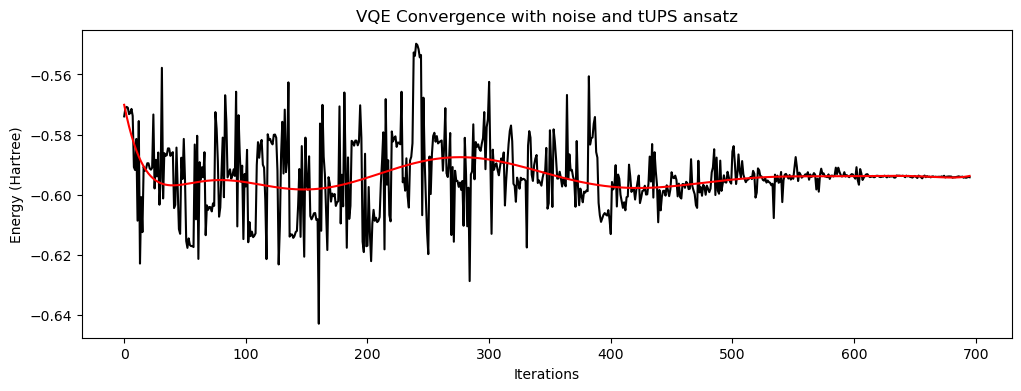

In [214]:
counts_noise_tups = np.arange(0, max_evaluations_noise_tups)
coeffs = Polynomial.fit(counts_noise_tups, average_values_noise_tups, deg=10)
poly_fit = coeffs(counts_noise_tups)

pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts_noise_tups, average_values_noise_tups, label="Average Energy", color="black")
plt.plot(counts_noise_tups, poly_fit, color='red', label='Polinomial fit', linewidth=1.5)
pylab.xlabel("Iterations")
pylab.ylabel("Energy (Hartree)")
pylab.title("VQE Convergence with noise and tUPS ansatz")
pylab.savefig('vqe_noise_tups_avg_try')

print("Averaged groundstate energy (Hartree units):", average_values_noise_tups[-1])


In [88]:
probs_to_plot = [probs_noise_ander_min_noise_tups, probs_noise_ander_min_noise_uccsd]

legend = ['tUPS','UCCSD']
title = 'Probability distribution for ground state after noisy VQE with noisy tUPS and UCCSD'
filename = 'histo_noise_tups_uccsd'

plot_histogram(probs_to_plot, bar_labels=False, legend=legend, title=title, filename=filename, figsize=(17,7) )

In [89]:
probs_to_plot = [probs_noise_ander_min_noisefree_tups, probs_noise_ander_min_noisefree_uccsd]

legend = ['tUPS','UCCSD']
title = 'Probability distribution for ground state after noisy VQE with noisy tUPS and UCCSD'
filename = 'histo_noisefree_tups_uccsd'

plot_histogram(probs_to_plot, bar_labels=False, legend=legend, title=title, filename=filename, figsize=(17,7) )

Mean for UCCSD and Mr Anderson after noisless VQE: 7.3536575441553325
Standard deviation for UCCSD and Mr Anderson after noisless VQE: 3.3616270602663176
Mean for tUPS and Mr Anderson after noiseless VQE: 7.422948351563368
Standard deviation for tUPS and Mr Anderson after noisless VQE: 4.611255088740771


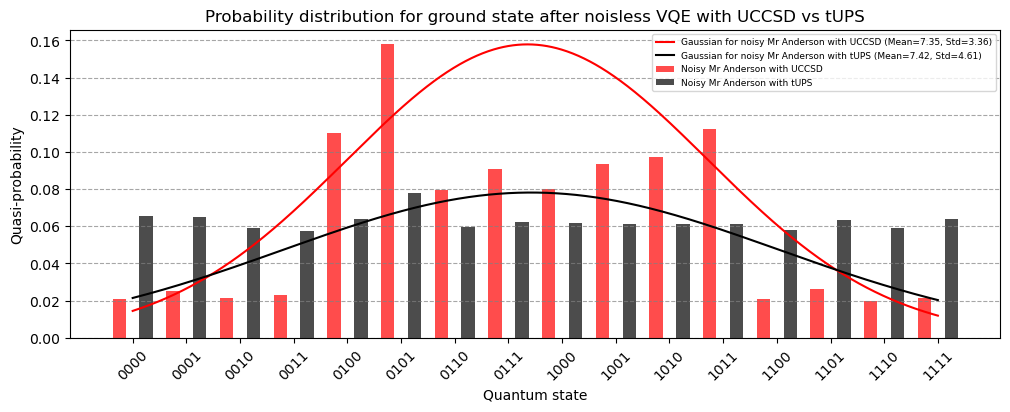

In [382]:
from scipy.stats import norm

# Noisless VQE and noisy UCCSD Mr Anderson 
states_as_integers = [int(state, 2) for state in probs_noise_ander_min_noisefree_uccsd.keys()]
probabilities_noise_ander_min_noisefree_uccsd = np.array(list(probs_noise_ander_min_noisefree_uccsd.values()))
mean_noise_ander_min_noisefree_uccsd = np.sum(np.array(states_as_integers) * probabilities_noise_ander_min_noisefree_uccsd)
print(f"Mean for UCCSD and Mr Anderson after noisless VQE: {mean_noise_ander_min_noisefree_uccsd}")

squared_diff = np.sum((np.arange(16) - mean_noise_ander_min_noisefree_uccsd) ** 2 * np.array(np.array(list(probs_noise_ander_min_noisefree_uccsd.values()))))  
sigma_noise_ander_min_noisefree_uccsd = np.sqrt(squared_diff)
print(f"Standard deviation for UCCSD and Mr Anderson after noisless VQE: {sigma_noise_ander_min_noisefree_uccsd}")

x = np.linspace(0, 15, 1000)  
gaussian_noise_ander_min_noisefree_uccsd = norm.pdf(x, mean_noise_ander_min_noisefree_uccsd , sigma_noise_ander_min_noisefree_uccsd)  
max_gaussian_value = max(gaussian_noise_ander_min_noisefree_uccsd)  
gaussian_noise_ander_min_noisefree_uccsd = gaussian_noise_ander_min_noisefree_uccsd / max_gaussian_value * max(probs_noise_ander_min_noisefree_uccsd.values()) 



# Noisless VQE and noisy tUPS Mr Anderson 
states_as_integers = [int(state, 2) for state in probs_noise_ander_min_noisefree_tups.keys()]
probabilities_noise_ander_min_noisefree_tups = np.array(list(probs_noise_ander_min_noisefree_tups.values()))
mean_noise_ander_min_noisefree_tups = np.sum(np.array(states_as_integers) * probabilities_noise_ander_min_noisefree_tups)
print(f"Mean for tUPS and Mr Anderson after noiseless VQE: {mean_noise_ander_min_noisefree_tups}")

squared_diff = np.sum((np.arange(16) - mean_noise_ander_min_noisefree_tups) ** 2 * np.array(np.array(list(probs_noise_ander_min_noisefree_tups.values()))))  
sigma_noise_ander_min_noisefree_tups = np.sqrt(squared_diff)
print(f"Standard deviation for tUPS and Mr Anderson after noisless VQE: {sigma_noise_ander_min_noisefree_tups}")

x = np.linspace(0, 15, 1000)  
gaussian_noise_ander_min_noisefree_tups = norm.pdf(x, mean_noise_ander_min_noisefree_tups , sigma_noise_ander_min_noisefree_tups)  
max_gaussian_value = max(gaussian_noise_ander_min_noisefree_tups)  
gaussian_noise_ander_min_noisefree_tups = gaussian_noise_ander_min_noisefree_tups / max_gaussian_value * max(probs_noise_ander_min_noisefree_tups.values())


states = list(probs_noise_ander_min_noisefree_tups.keys())
states.sort()
x_pos = np.arange(len(states))  
bar_width = 0.25
fig, ax = plt.subplots()

ax.bar(x_pos - bar_width, probabilities_noise_ander_min_noisefree_uccsd,  width=bar_width, color='red', alpha=0.7, label="Noisy Mr Anderson with UCCSD")
ax.plot(x, gaussian_noise_ander_min_noisefree_uccsd, 'r-', label=f'Gaussian for noisy Mr Anderson with UCCSD (Mean={mean_noise_ander_min_noisefree_uccsd:.2f}, Std={sigma_noise_ander_min_noisefree_uccsd:.2f})')


ax.bar(x_pos + bar_width, probabilities_noise_ander_min_noisefree_tups, width=bar_width, color='black', alpha=0.7, label="Noisy Mr Anderson with tUPS")
ax.plot(x, gaussian_noise_ander_min_noisefree_tups, 'k-', label=f'Gaussian for noisy Mr Anderson with tUPS (Mean={mean_noise_ander_min_noisefree_tups:.2f}, Std={sigma_noise_ander_min_noisefree_tups:.2f})')

ax.set_xlabel('Quantum state')
ax.set_ylabel('Quasi-probability')
ax.set_title('Probability distribution for ground state after noisless VQE with UCCSD vs tUPS')
ax.legend(loc='upper right',fontsize=6.5)
plt.xticks(x_pos, states, rotation=45)
plt.grid(axis='y', linestyle='--', color='gray', alpha=0.7)
plt.savefig('histograma_noisefreevqe_uccsd_tups')
plt.show()

Mean for UCCSD and Mr Anderson after noisy VQE: 7.478624448490823
Standard deviation for UCCSD and Mr Anderson after noisy VQE: 3.3169514802315017
Mean for tUPS and Mr Anderson after noisy VQE: 7.513664071623756
Standard deviation for tUPS and Mr Anderson after noisy VQE: 4.620133051768467


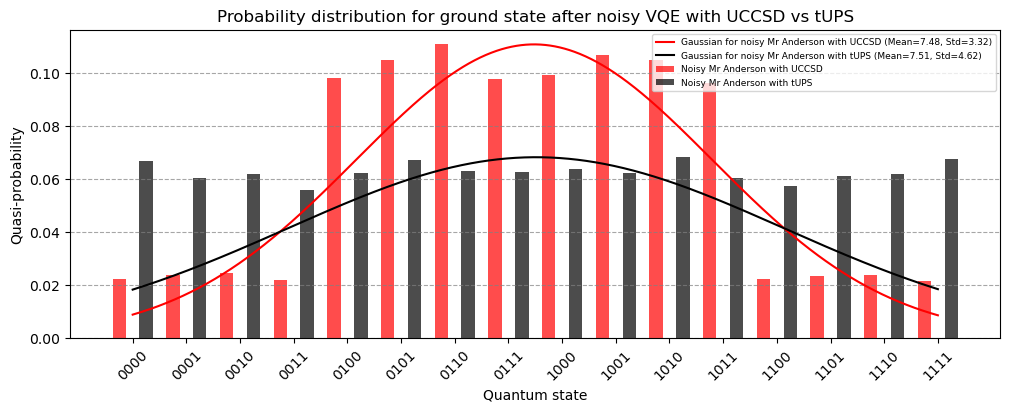

In [381]:
from scipy.stats import norm


# Noisy VQE and noisy UCCSD Mr Anderson 
states_as_integers = [int(state, 2) for state in probs_noise_ander_min_noise_uccsd.keys()]
probabilities_noise_ander_min_noise_uccsd = np.array(list(probs_noise_ander_min_noise_uccsd.values()))
mean_noise_ander_min_noise_uccsd = np.sum(np.array(states_as_integers) * probabilities_noise_ander_min_noise_uccsd)
print(f"Mean for UCCSD and Mr Anderson after noisy VQE: {mean_noise_ander_min_noise_uccsd}")

squared_diff = np.sum((np.arange(16) - mean_noise_ander_min_noise_uccsd) ** 2 * np.array(np.array(list(probs_noise_ander_min_noise_uccsd.values()))))  
sigma_noise_ander_min_noise_uccsd = np.sqrt(squared_diff)
print(f"Standard deviation for UCCSD and Mr Anderson after noisy VQE: {sigma_noise_ander_min_noise_uccsd}")

x = np.linspace(0, 15, 1000)  
gaussian_noise_ander_min_noise_uccsd = norm.pdf(x, mean_noise_ander_min_noise_uccsd , sigma_noise_ander_min_noise_uccsd)  
max_gaussian_value = max(gaussian_noise_ander_min_noise_uccsd)  
gaussian_noise_ander_min_noise_uccsd = gaussian_noise_ander_min_noise_uccsd / max_gaussian_value * max(probs_noise_ander_min_noise_uccsd.values()) 



# Noisy VQE and noisy tUPS Mr Anderson 
states_as_integers = [int(state, 2) for state in probs_noise_ander_min_noise_tups.keys()]
probabilities_noise_ander_min_noise_tups = np.array(list(probs_noise_ander_min_noise_tups.values()))
mean_noise_ander_min_noise_tups = np.sum(np.array(states_as_integers) * probabilities_noise_ander_min_noise_tups)
print(f"Mean for tUPS and Mr Anderson after noisy VQE: {mean_noise_ander_min_noise_tups}")

squared_diff = np.sum((np.arange(16) - mean_noise_ander_min_noise_tups) ** 2 * np.array(np.array(list(probs_noise_ander_min_noise_tups.values()))))  
sigma_noise_ander_min_noise_tups = np.sqrt(squared_diff)
print(f"Standard deviation for tUPS and Mr Anderson after noisy VQE: {sigma_noise_ander_min_noise_tups}")

x = np.linspace(0, 15, 1000)  
gaussian_noise_ander_min_noise_tups = norm.pdf(x, mean_noise_ander_min_noise_tups , sigma_noise_ander_min_noise_tups)  
max_gaussian_value = max(gaussian_noise_ander_min_noise_tups)  
gaussian_noise_ander_min_noise_tups = gaussian_noise_ander_min_noise_tups / max_gaussian_value * max(probs_noise_ander_min_noise_tups.values()) 


states = list(probs_noise_ander_min_noise_tups.keys())
states.sort()
x_pos = np.arange(len(states))  
bar_width = 0.25
fig, ax = plt.subplots()

ax.bar(x_pos - bar_width, probabilities_noise_ander_min_noise_uccsd,  width=bar_width, color='red', alpha=0.7, label="Noisy Mr Anderson with UCCSD")
ax.plot(x, gaussian_noise_ander_min_noise_uccsd, 'r-', label=f'Gaussian for noisy Mr Anderson with UCCSD (Mean={mean_noise_ander_min_noise_uccsd:.2f}, Std={sigma_noise_ander_min_noise_uccsd:.2f})')


ax.bar(x_pos + bar_width, probabilities_noise_ander_min_noise_tups, width=bar_width, color='black', alpha=0.7, label="Noisy Mr Anderson with tUPS")
ax.plot(x, gaussian_noise_ander_min_noise_tups, 'k-', label=f'Gaussian for noisy Mr Anderson with tUPS (Mean={mean_noise_ander_min_noise_tups:.2f}, Std={sigma_noise_ander_min_noise_tups:.2f})')

ax.set_xlabel('Quantum state')
ax.set_ylabel('Quasi-probability')
ax.set_title('Probability distribution for ground state after noisy VQE with UCCSD vs tUPS')
ax.legend(loc='upper right',fontsize=6.5)
plt.xticks(x_pos, states, rotation=45)
plt.grid(axis='y', linestyle='--', color='gray', alpha=0.7)
plt.savefig('histograma_noisyvqe_uccsd_tups')
plt.show()

In [178]:
probs_free_ander_min_noisefree_tups_fide = np.array(list(probs_free_ander_min_noisefree_tups.values()))
probs_noise_ander_min_noise_uccsd_fide = np.array(list(probs_noise_ander_min_noise_uccsd.values()))

fidelity = np.sum(np.sqrt(probs_free_ander_min_noisefree_tups_fide * probs_noise_ander_min_noise_uccsd_fide)) ** 2
print(f"Fidelidad: {fidelity:.4f}")

Fidelidad: 0.1789


In [181]:
probs_free_ander_min_noisefree_tups_fide = np.array(list(probs_free_ander_min_noisefree_tups.values()))
probs_noise_ander_min_noise_tups_fide = np.array(list(probs_noise_ander_min_noise_tups.values()))

fidelity = np.sum(np.sqrt(probs_free_ander_min_noisefree_tups_fide * probs_noise_ander_min_noise_tups_fide)) ** 2
print(f"Fidelidad: {fidelity:.4f}")

Fidelidad: 0.1121


In [180]:
probs_free_ander_min_noisefree_tups_fide = np.array(list(probs_free_ander_min_noisefree_tups.values()))
probs_noise_ander_min_noisefree_uccsd_fide = np.array(list(probs_noise_ander_min_noisefree_uccsd.values()))

fidelity = np.sum(np.sqrt(probs_free_ander_min_noisefree_tups_fide * probs_noise_ander_min_noisefree_uccsd_fide)) ** 2
print(f"Fidelity: {fidelity:.4f}")

Fidelity: 0.2351


In [179]:
probs_free_ander_min_noisefree_tups_fide = np.array(list(probs_free_ander_min_noisefree_tups.values()))
probs_noise_ander_min_noisefree_tups_fide = np.array(list(probs_noise_ander_min_noisefree_tups.values()))

fidelity = np.sum(np.sqrt(probs_free_ander_min_noisefree_tups_fide * probs_noise_ander_min_noisefree_tups_fide)) ** 2
print(f"Fidelity: {fidelity:.4f}")

Fidelity: 0.1246


In [280]:
estados = [format(i, '04b') for i in range(16)]
print(estados)
#probs_noise_ander_min_noisefree_uccsd = dict(zip(estados, probs_noise_ander_min_noisefree_uccsd))
print(probs_noise_ander_min_noisefree_uccsd)

['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']
{'0000': np.float64(0.020608533189945277), '0001': np.float64(0.02529552548486238), '0010': np.float64(0.02145835701397135), '0011': np.float64(0.023078010098126402), '0100': np.float64(0.11015009529991993), '0101': np.float64(0.1578627444859783), '0110': np.float64(0.07960757422649214), '0111': np.float64(0.09106628003180714), '1000': np.float64(0.08006525913241719), '1001': np.float64(0.0933765878532666), '1010': np.float64(0.09748120894578768), '1011': np.float64(0.1124585108064445), '1100': np.float64(0.02071629159992815), '1101': np.float64(0.02614563154351553), '1110': np.float64(0.019508870508429785), '1111': np.float64(0.02112051977910758)}


In [7]:
backend = FakeKyiv()
#backend = provider.backend('ibm_kyiv')
print(backend.qubit_properties(0))
print(backend.qubit_properties(1))
print(backend.qubit_properties(2))
print(backend.qubit_properties(3))
config = backend.configuration()
print("Número de qubits:", config.n_qubits)

QubitProperties(t1=0.00036403810294451946, t2=0.00034854936444011657, frequency=4655609332.053975)
QubitProperties(t1=0.0005690055349559576, t2=0.00023207678408770585, frequency=4534975859.426203)
QubitProperties(t1=0.0003052640970754664, t2=0.0001197420446260147, frequency=4680110183.2333765)
QubitProperties(t1=0.00034493619450739663, t2=0.0001656597804188118, frequency=4606655659.877273)
Número de qubits: 127


In [3]:
properties = backend.properties()
for qubit, qubit_props in enumerate(properties.qubits):
    t1 = qubit_props[0].value  # T1
    t2 = qubit_props[1].value  # T2
    print(f"Qubit {qubit}: T1={t1:.2e} s, T2={t2:.2e} s")

Qubit 0: T1=3.64e+02 s, T2=3.49e+02 s
Qubit 1: T1=5.69e+02 s, T2=2.32e+02 s
Qubit 2: T1=3.05e+02 s, T2=1.20e+02 s
Qubit 3: T1=3.45e+02 s, T2=1.66e+02 s
Qubit 4: T1=4.37e+02 s, T2=1.11e+02 s
Qubit 5: T1=2.21e+02 s, T2=3.05e+02 s
Qubit 6: T1=3.89e+02 s, T2=1.92e+02 s
Qubit 7: T1=4.21e+02 s, T2=3.71e+02 s
Qubit 8: T1=3.64e+02 s, T2=2.53e+02 s
Qubit 9: T1=4.82e+02 s, T2=5.08e+01 s
Qubit 10: T1=2.72e+02 s, T2=4.91e+01 s
Qubit 11: T1=3.81e+02 s, T2=3.25e+02 s
Qubit 12: T1=4.50e+02 s, T2=3.06e+02 s
Qubit 13: T1=3.55e+02 s, T2=7.77e+01 s
Qubit 14: T1=2.94e+02 s, T2=1.97e+02 s
Qubit 15: T1=4.30e+02 s, T2=7.53e+01 s
Qubit 16: T1=1.19e+02 s, T2=9.04e+01 s
Qubit 17: T1=1.97e+02 s, T2=4.80e+01 s
Qubit 18: T1=3.74e+02 s, T2=5.32e+01 s
Qubit 19: T1=2.18e+02 s, T2=2.07e+02 s
Qubit 20: T1=4.83e+02 s, T2=4.37e+02 s
Qubit 21: T1=4.03e+02 s, T2=7.77e+01 s
Qubit 22: T1=3.90e+02 s, T2=1.47e+02 s
Qubit 23: T1=2.56e+02 s, T2=1.38e+02 s
Qubit 24: T1=3.19e+02 s, T2=8.99e+01 s
Qubit 25: T1=2.27e+02 s, T2=2.62e+0